# Report kappas, no rampup(50 eps, 3 pretr)


baseline - 97.7%

sup+som (kappa 0.01) - 98.6%

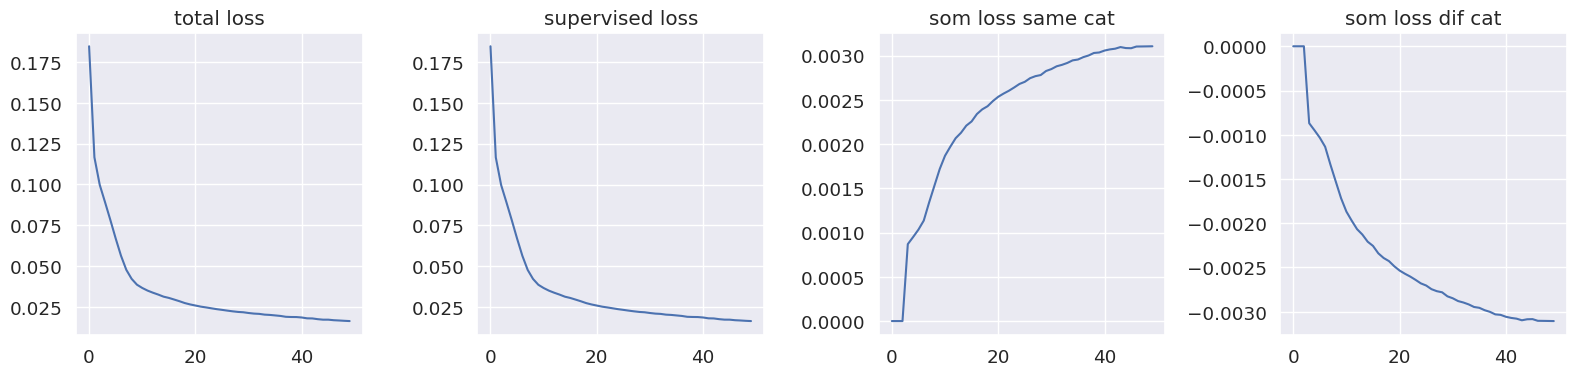

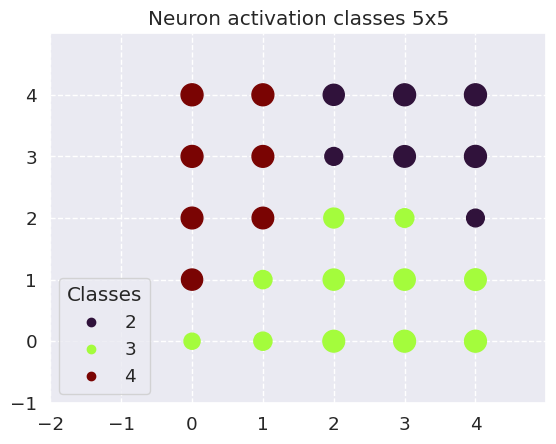

sup+som (kappa 0.1) - 100%

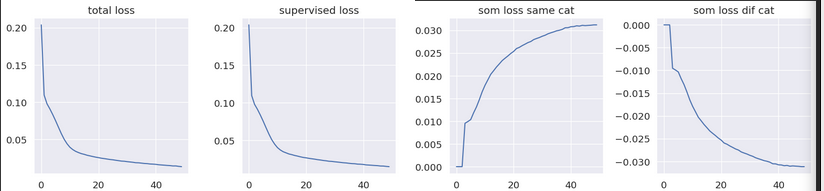

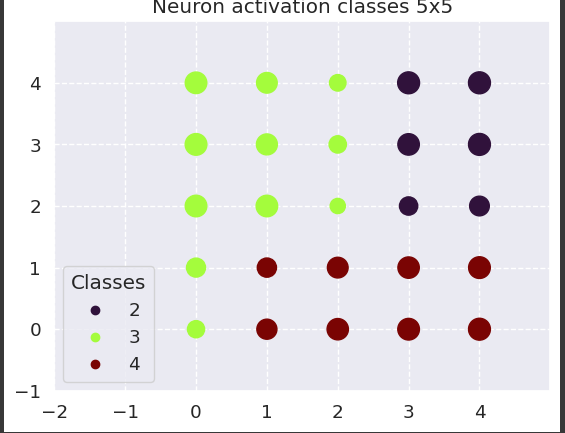


sup+som (kappa 10) - 99.3%

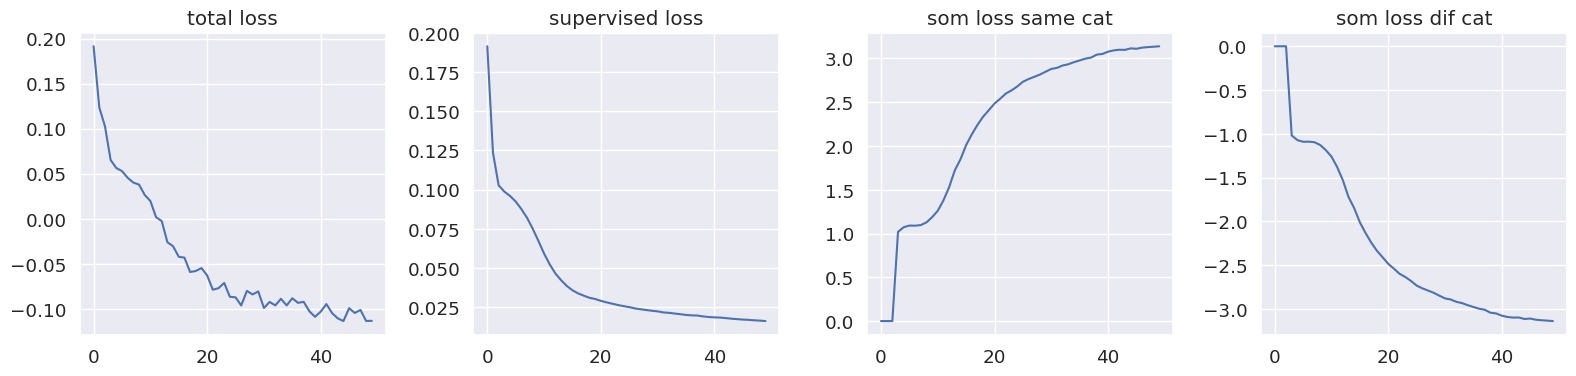

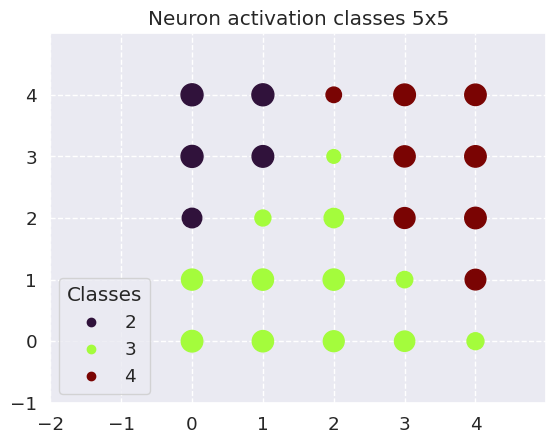


sup+som (kappa 100) - 98.7%

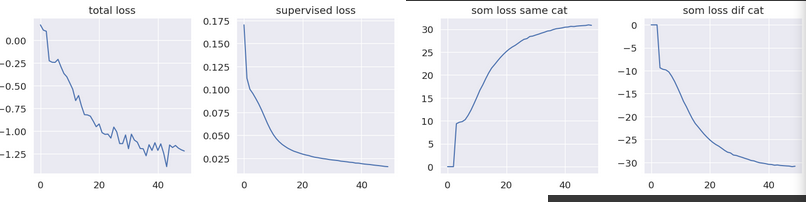

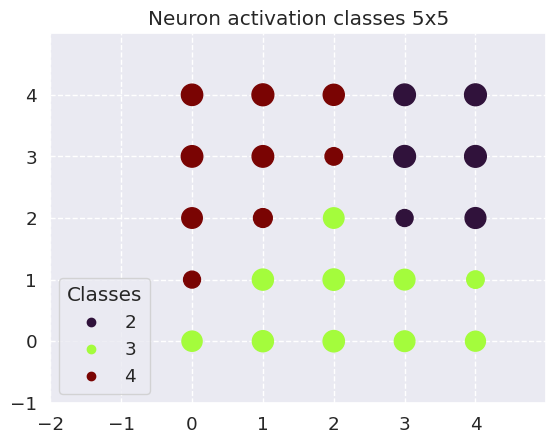

# Report kappas, linear rampup(50 eps, 3 pretr)



kappa = 0.01, acc = 99.3 %

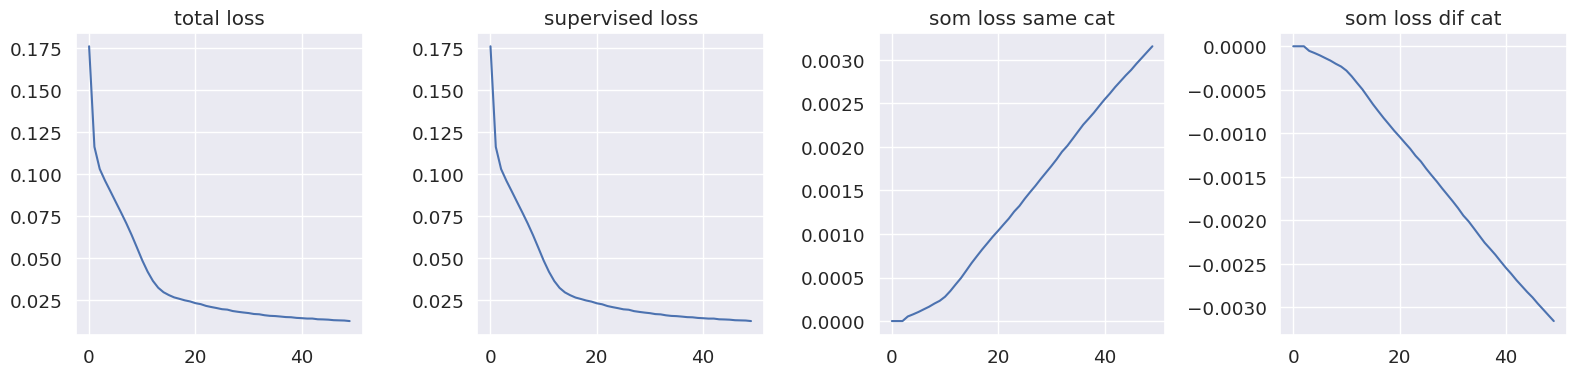

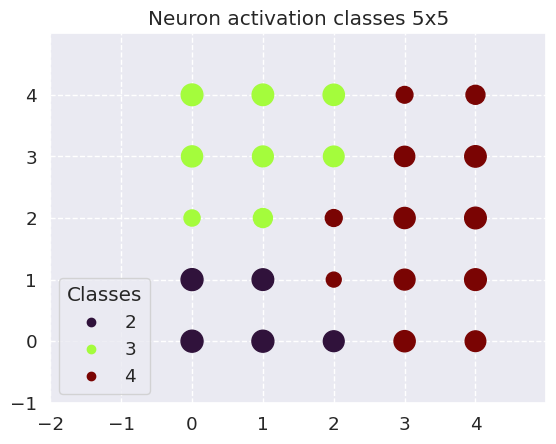

kappa = 0.1, acc = 98.7 %

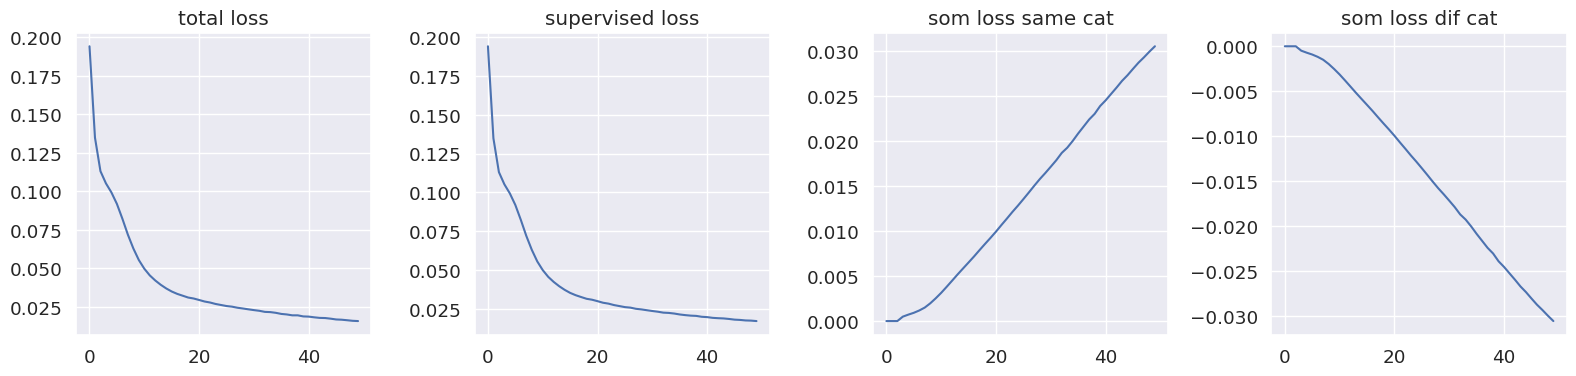

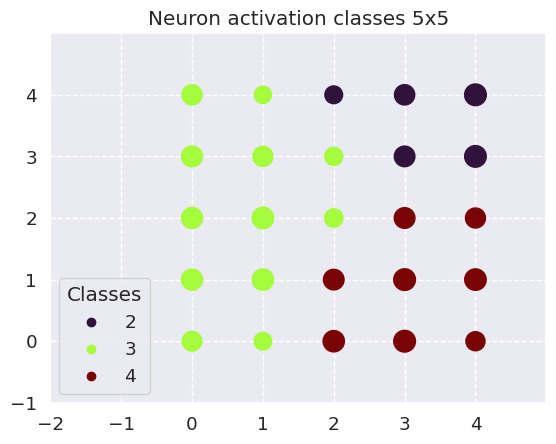

kappa = 10, acc = 97.9 %

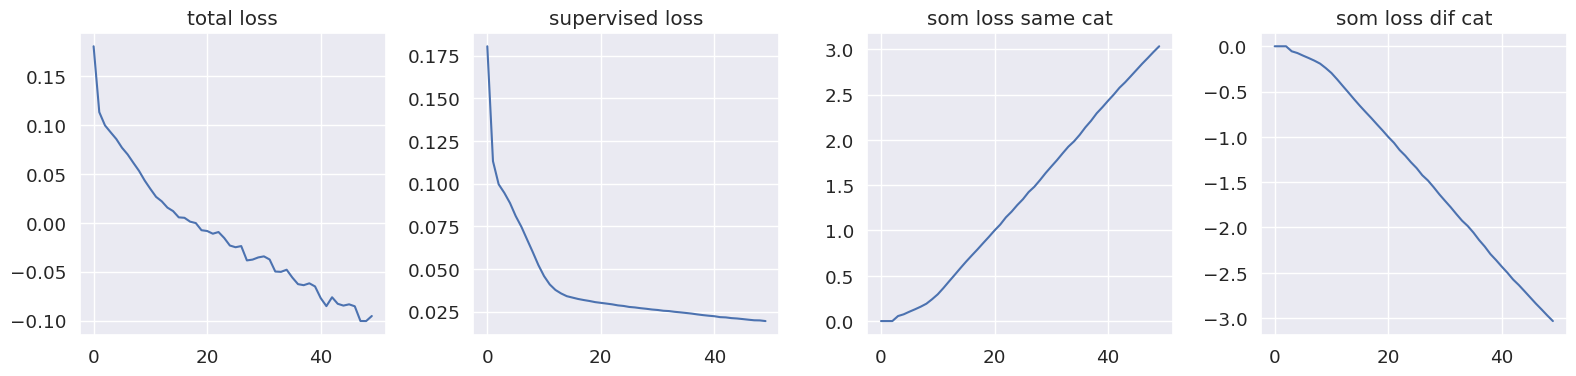

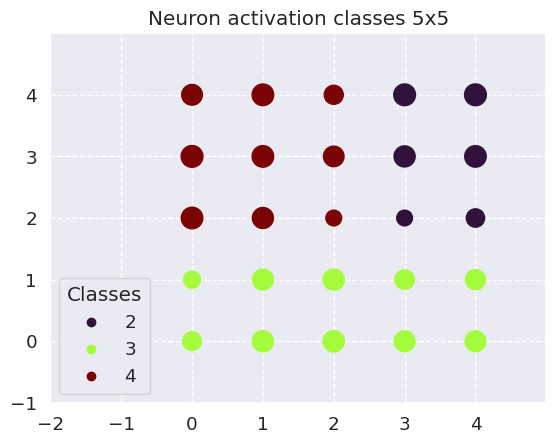

kappa = 100, acc = 99.3 %

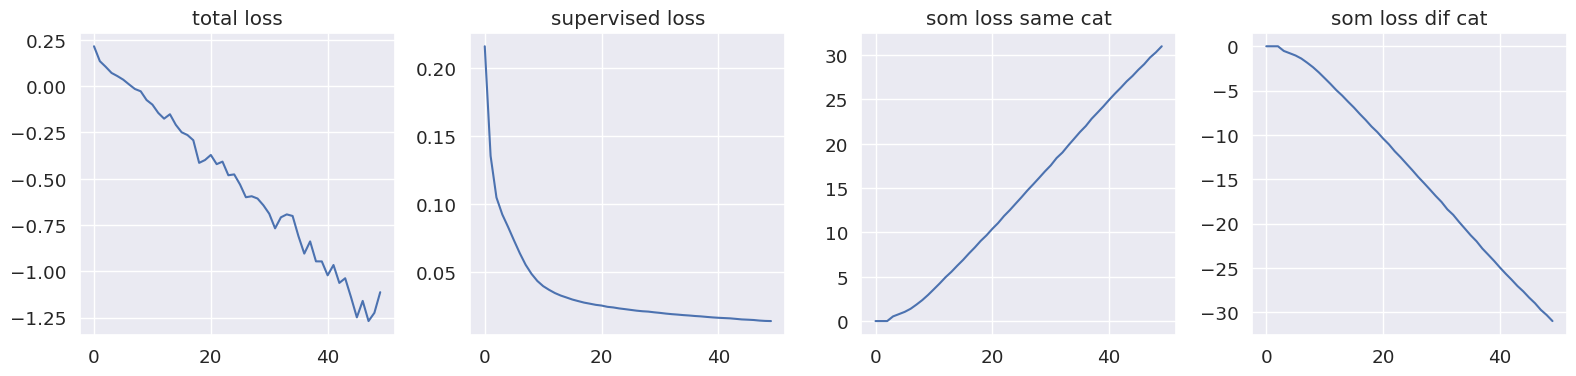

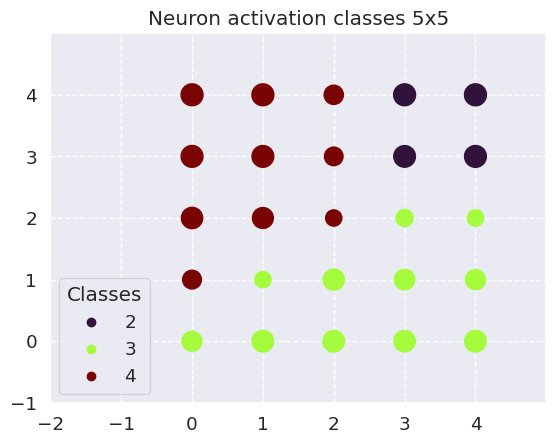


# Baseline MLP triplets


50 eps, 5 experiments

acuuracies: [88.88888888888889, 88.88888888888889, 91.11111111111111, 88.88888888888889, 88.88888888888889]

ta najlepsia: 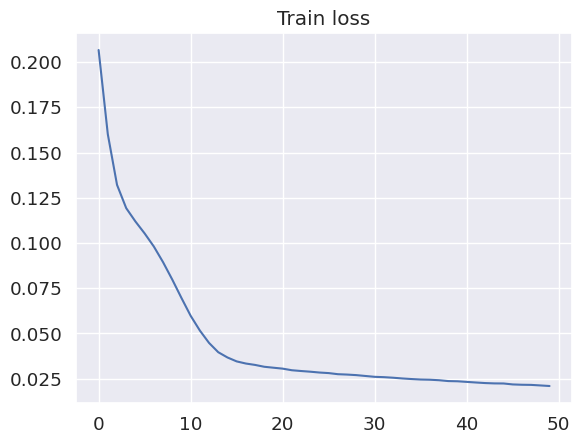

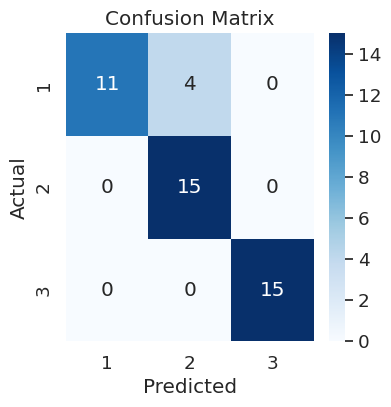

# Report triplets, kappas, lin rampup (50 eps, 1 pretr)

kappa = 0.1
acc = 93.3%

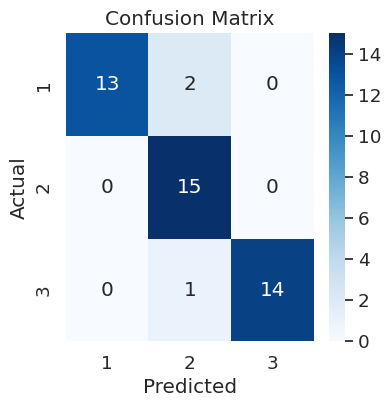
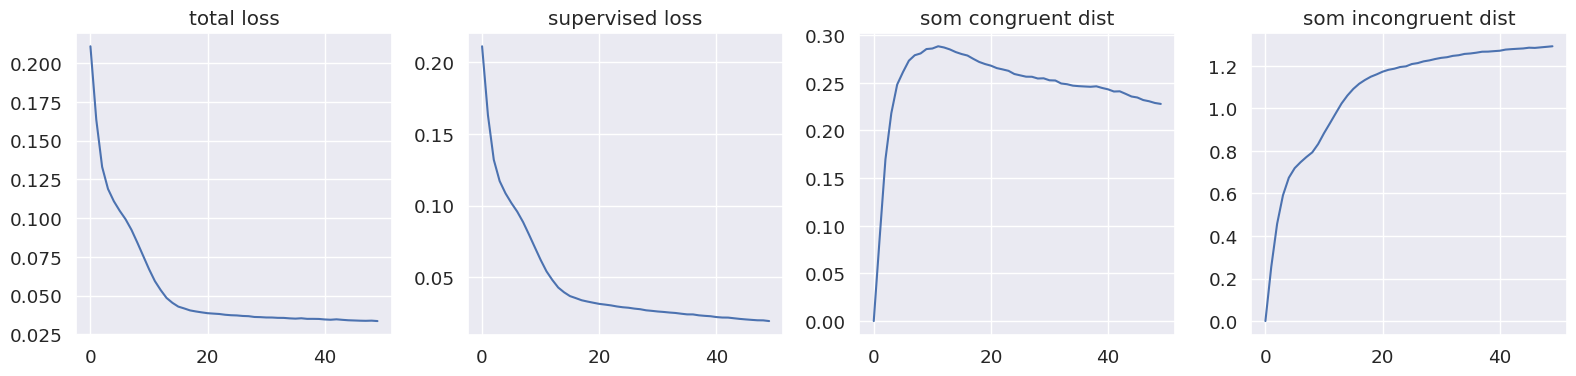 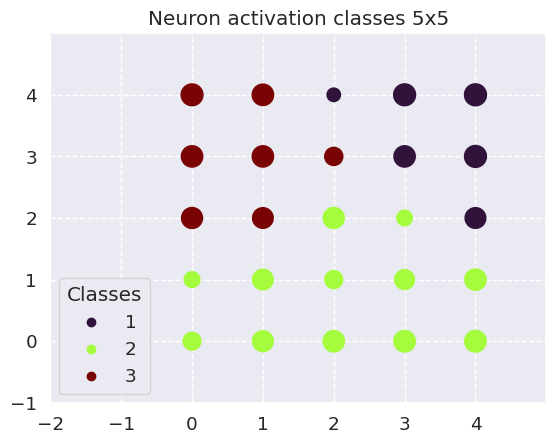 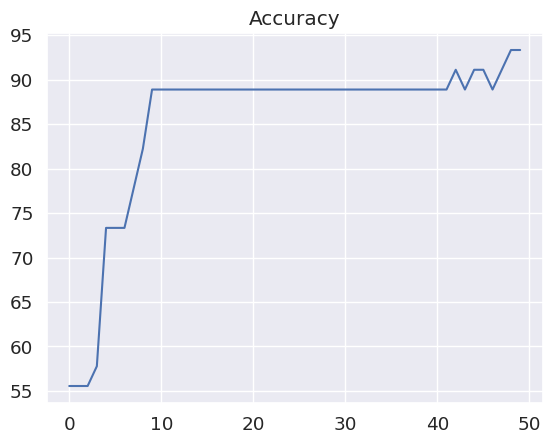

kappa = 10, acc = 33.3%

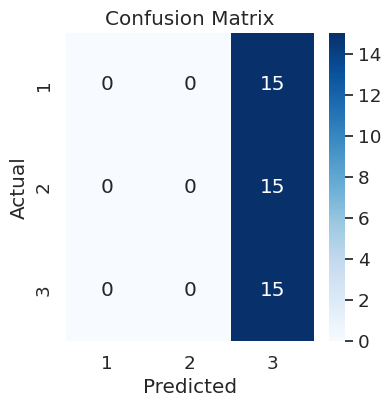

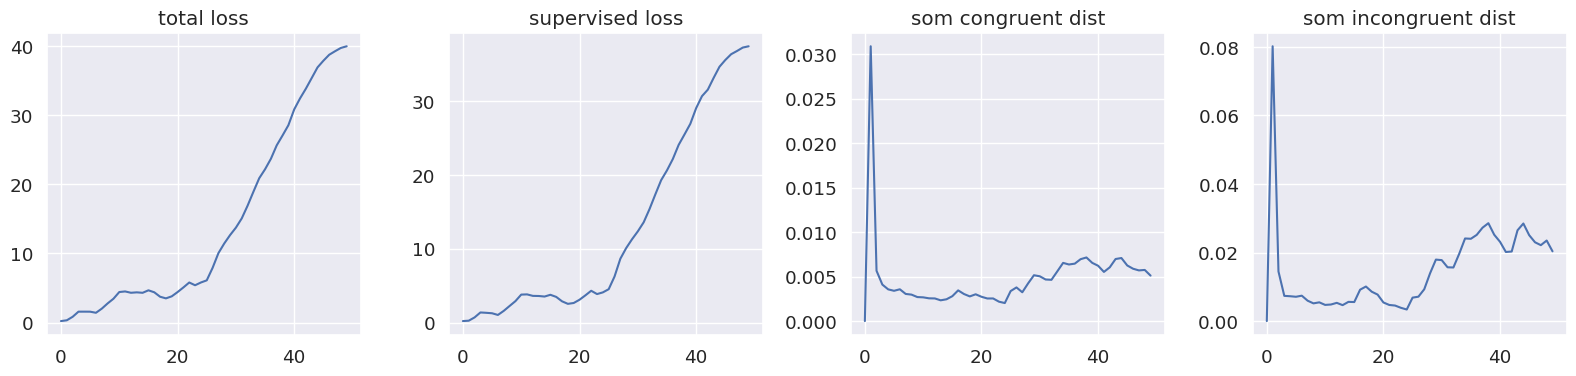

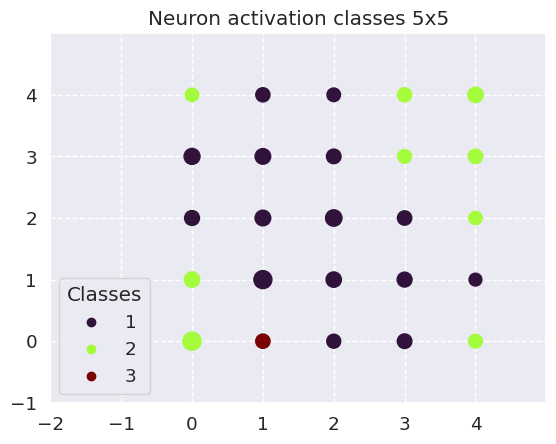

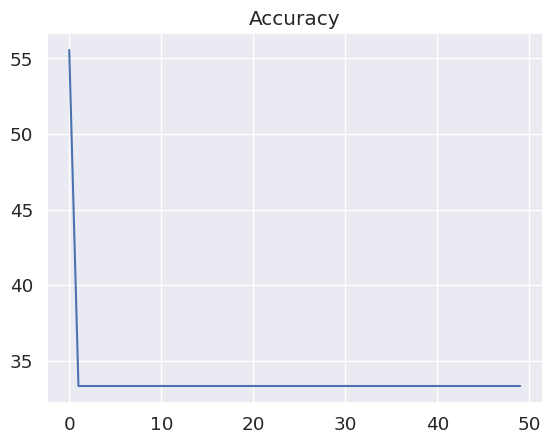

kappa = 1, acc = 88.9%

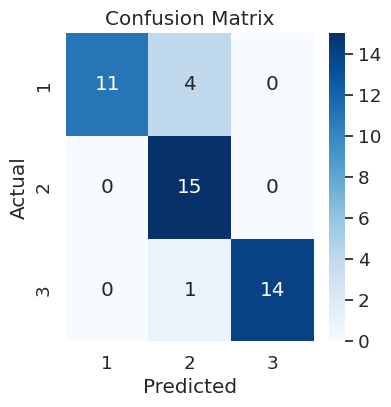

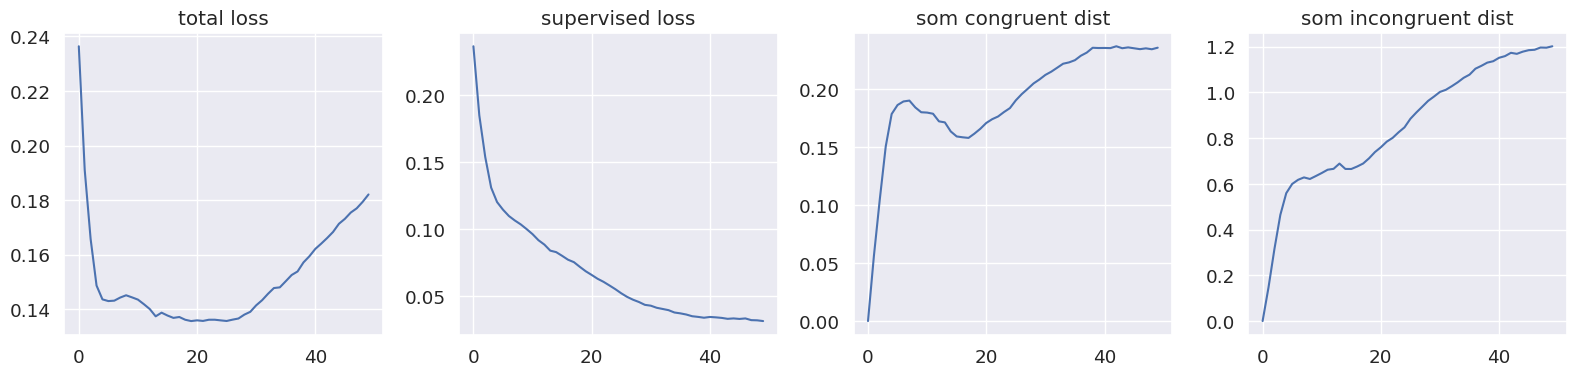

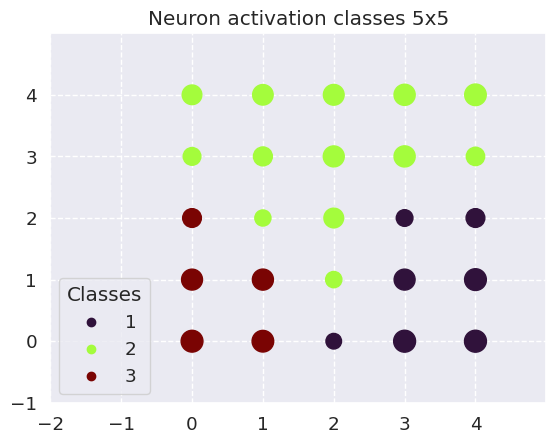

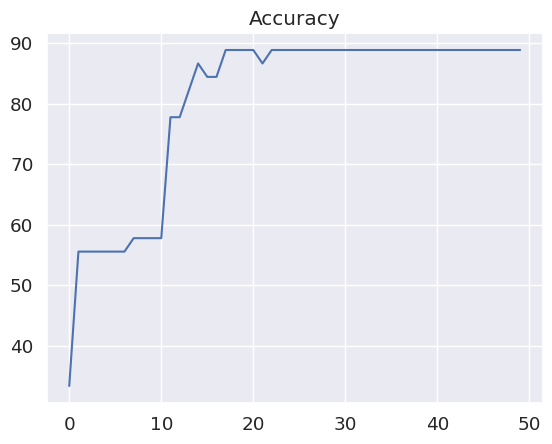

kappa = 0.01, acc = 88.9

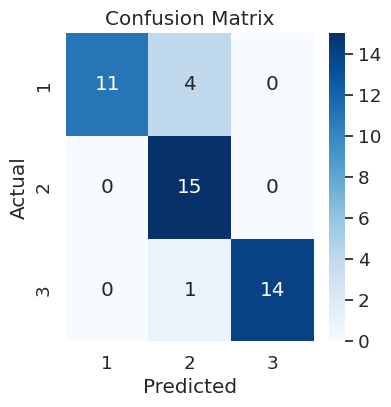

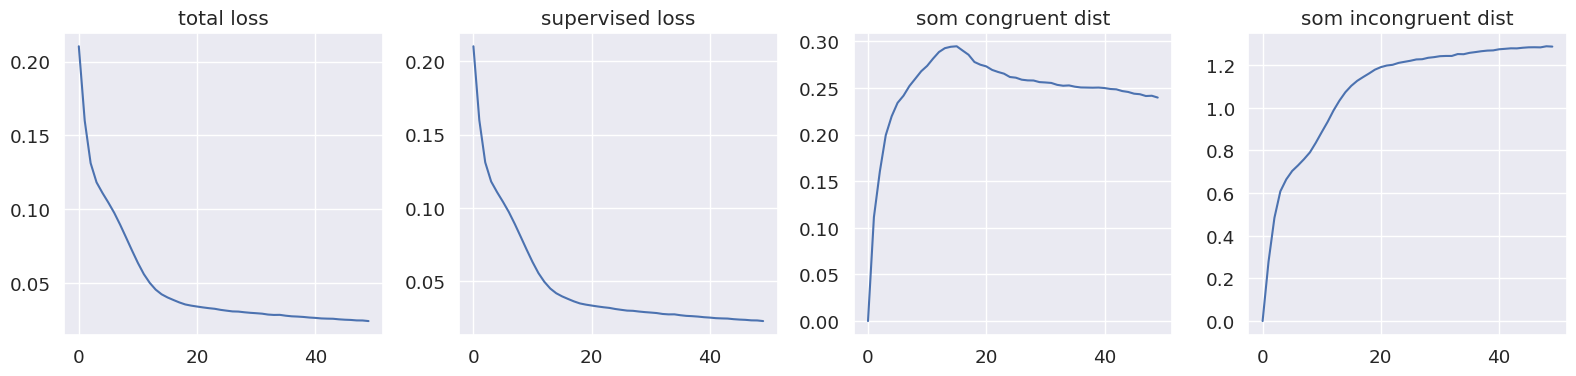

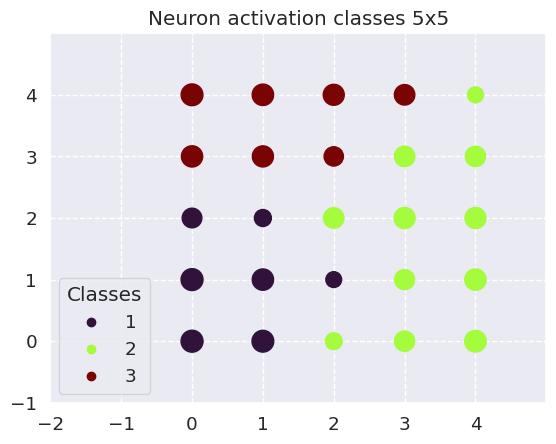

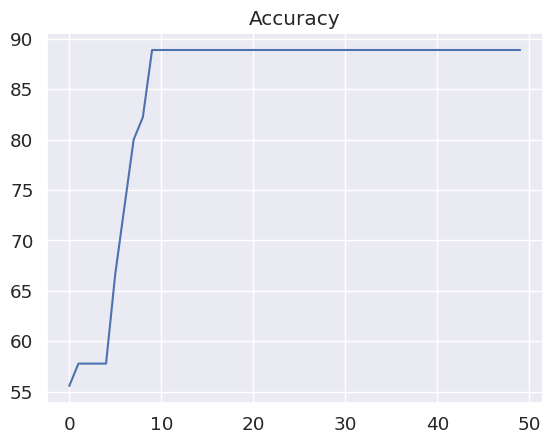

kappa = 0.05, acc = 88.9%

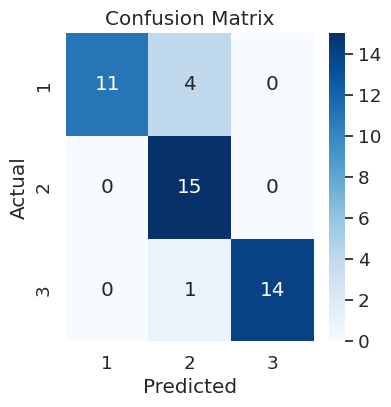

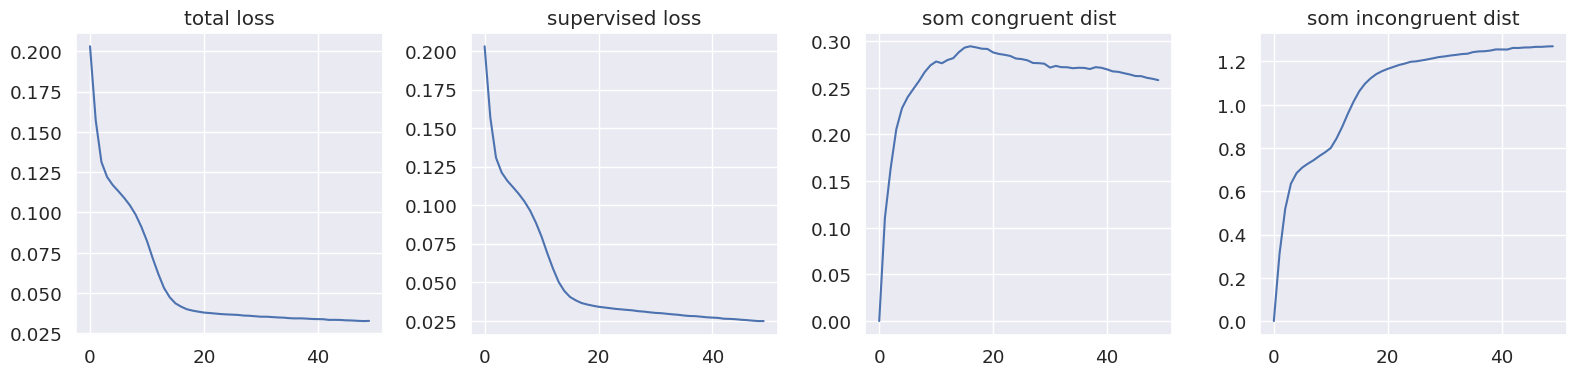

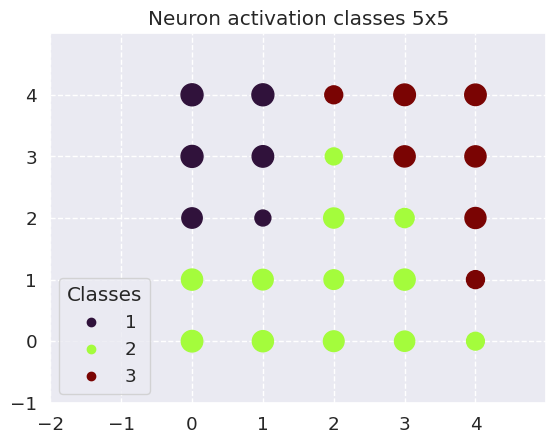

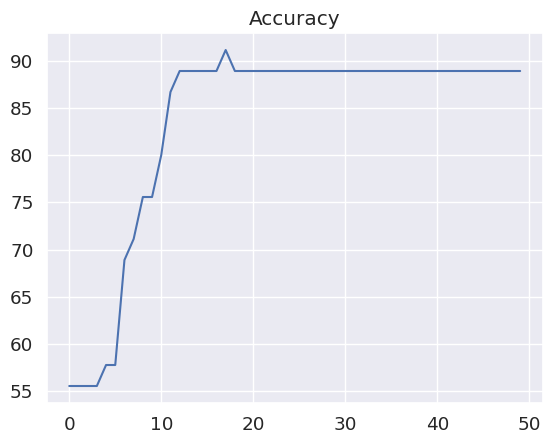

# Baseline MLP triplets Softmax



accs : [91.11111111111111, 91.11111111111111, 91.11111111111111, 91.11111111111111, 93.33333333333333]


best model stats:

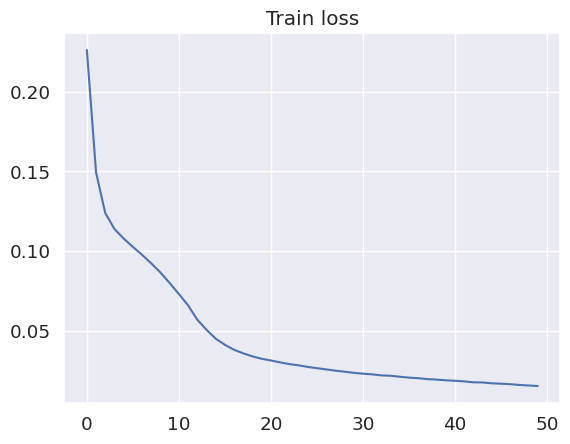


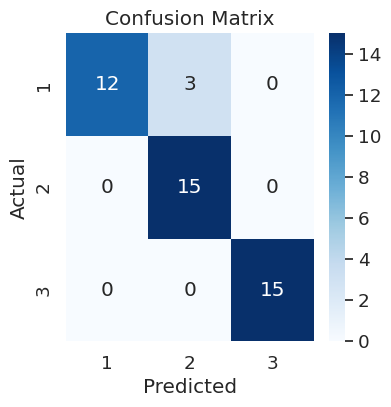

# Report triplets Softmax, lin rampup (50 ep, 1 pretr)

kappa = 0.1

best acc = 93.3, last acc = 91.11

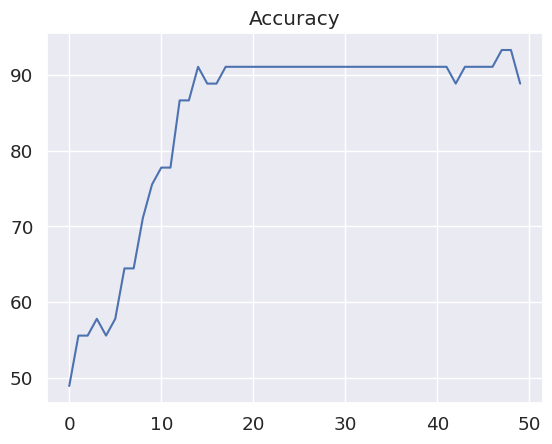

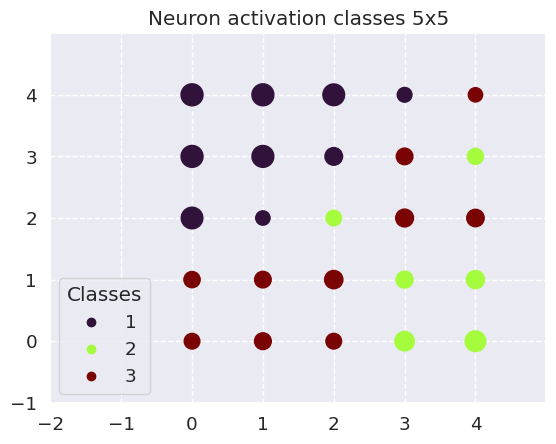

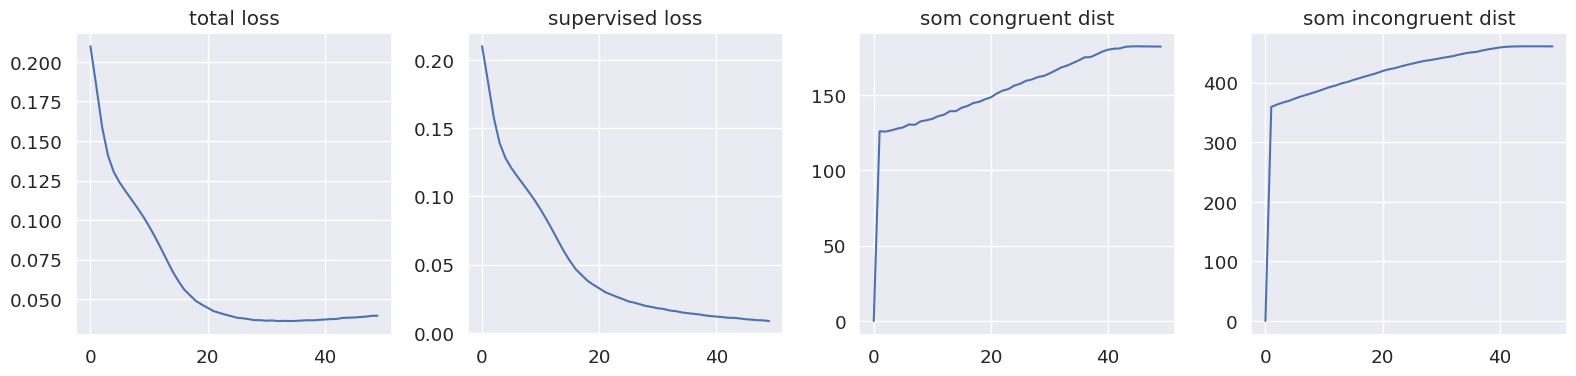

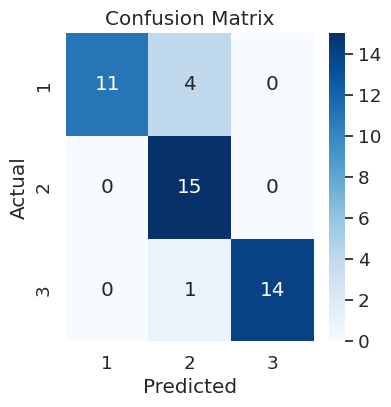

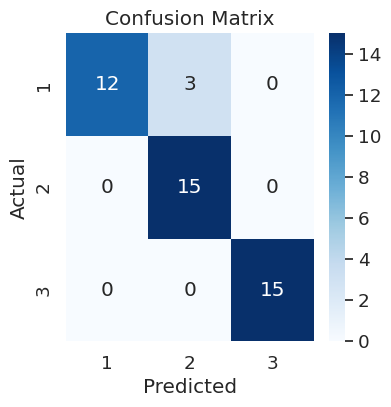

kappa = 0.01

best acc = 95.6, last = 88.9

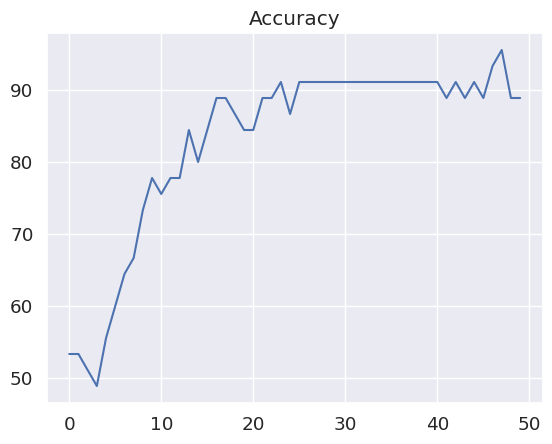

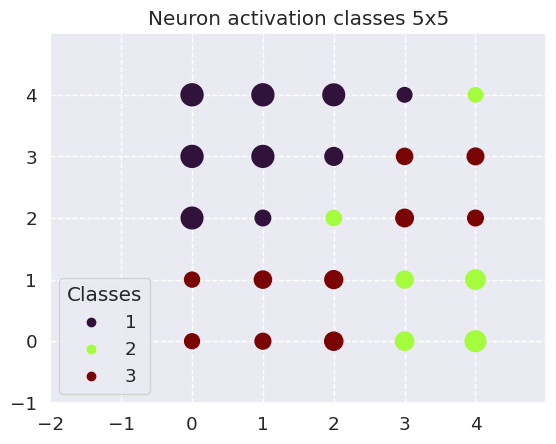

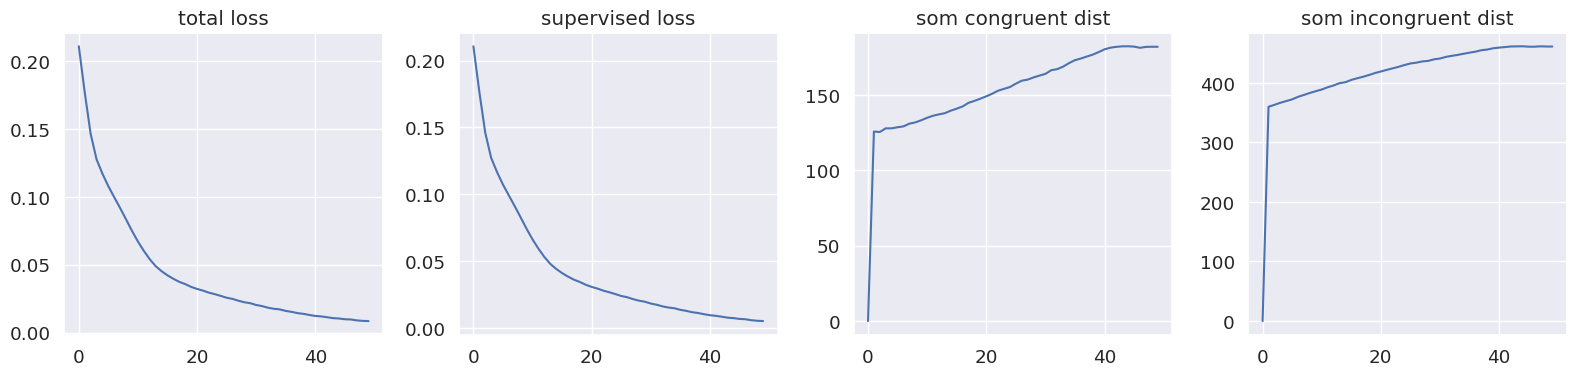

kappa = 10

acc = 95.6

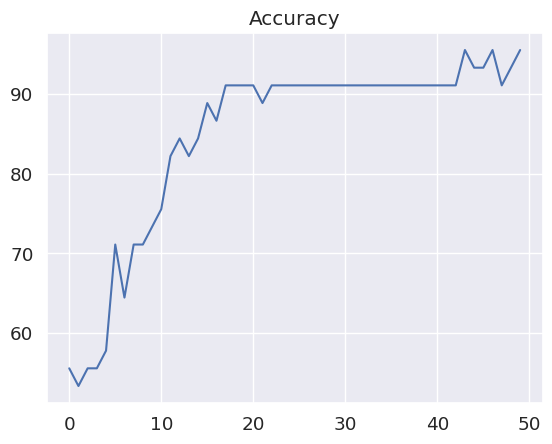

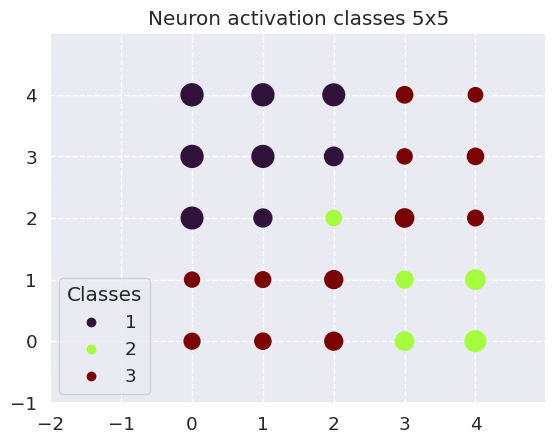

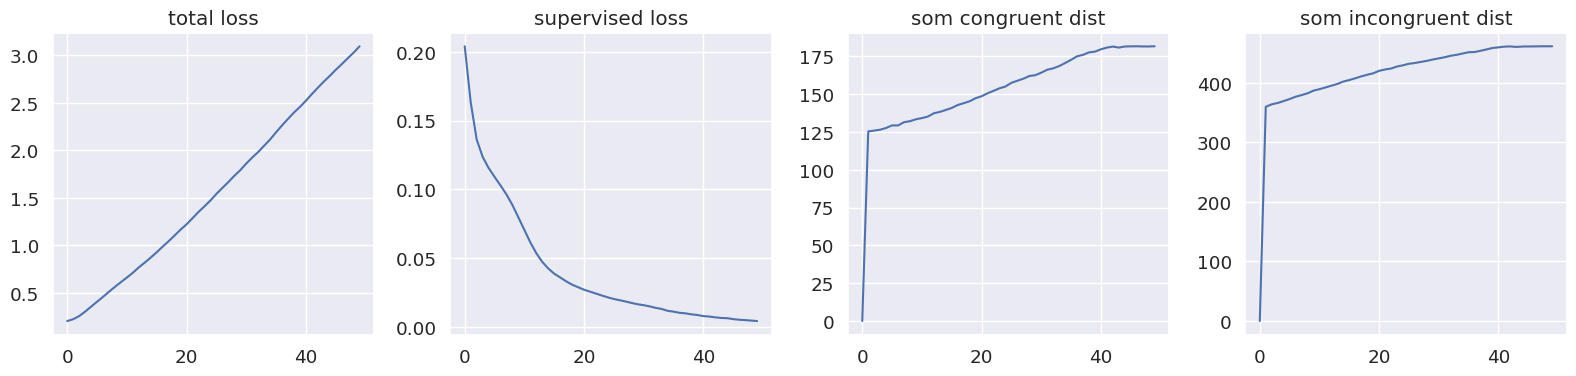

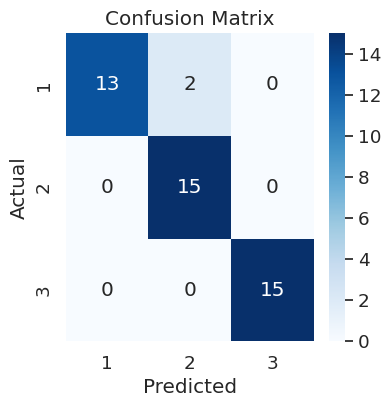

# Imports


In [ ]:
%pip install ucimlrepo # install wine dataset repo
from ucimlrepo import fetch_ucirepo

import numpy as np


import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.modules.loss import MSELoss
import torch.nn.functional as F


import sklearn.model_selection
from sklearn.metrics import confusion_matrix
import seaborn as sns


import matplotlib.pyplot as plt
from math import *

import time


device = "cuda" if torch.cuda.is_available() else "cpu"

# Data preparation


In [ ]:
# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = wine.data.features.to_numpy() # (178, 13)
y = wine.data.targets.to_numpy() # 1, 2 or 3

print(X.shape, y.shape)
dataset_arr = np.hstack((X, y))
batch_size = 30

(178, 13) (178, 1)


In [ ]:
# divide into classes
class1 = dataset_arr[:59] # 59x14
class2 = dataset_arr[59:130]
class3 = dataset_arr[130:]


# TODO nevadi ze to je nahodne a nie pseudonahodne ??
np.random.shuffle(class1) # 59x14
np.random.shuffle(class2)
np.random.shuffle(class3)


size = 48
class1 = class1[:48] # 48x14
class2 = class2[:48]
class3 = class3[:48]

print(class1.shape, class1[0])

dataset = []
paired_labels = []

for i in range(size):
  for j in range(size):
    if i != j:
      dataset.append((class1[i], class1[j]))
      paired_labels.append(1)
      dataset.append((class2[i], class2[j]))
      paired_labels.append(2)
      dataset.append((class3[i], class3[j]))
      paired_labels.append(3)

for i in range(size):
  for j in range(size):
    dataset.append((class1[i], class2[j]))
    paired_labels.append(4)
    dataset.append((class1[i], class3[j]))
    paired_labels.append(5)
    dataset.append((class2[i], class3[j]))
    paired_labels.append(6)


print(len(dataset)) # 13680 list of tuples of ndarrays of data and label

paired_train_dataset, paired_test_dataset, labels1, labels2 = sklearn.model_selection.train_test_split(dataset, paired_labels, test_size=0.25, random_state=42, shuffle=True, stratify=paired_labels)
print(len(paired_train_dataset), len(paired_test_dataset))


print("xx", np.array(paired_train_dataset).shape)
train_dataloader = DataLoader(torch.tensor(np.array(paired_train_dataset)).to(device), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(torch.tensor(np.array(paired_test_dataset)).to(device), batch_size=batch_size, shuffle=True)

som_dataloader = DataLoader(torch.tensor(np.concatenate((class1, class2, class3))).to(device) , shuffle=True)
print(len(som_dataloader))

(48, 14) [1.375e+01 1.730e+00 2.410e+00 1.600e+01 8.900e+01 2.600e+00 2.760e+00
 2.900e-01 1.810e+00 5.600e+00 1.150e+00 2.900e+00 1.320e+03 1.000e+00]
13680
10260 3420
xx (10260, 2, 14)
144


In [ ]:
def generate_triplet(x, class1, class2):
    cong = class1[np.random.randint(0, class1.shape[0])]
    incong1 = class2[np.random.randint(0, class2.shape[0])]
    return np.array((x, cong, incong1))

# divide into classes
class1 = dataset_arr[:59]
class2 = dataset_arr[59:130]
class3 = dataset_arr[130:]

# nahodne preusporiadanie so seedom
np.random.seed(4742)
np.random.shuffle(class1)
np.random.seed(4742)
np.random.shuffle(class2)
np.random.seed(4742)
np.random.shuffle(class3)

# test dataset
class_test_size = 15
test_dataset = np.vstack((class1[:class_test_size], class2[:class_test_size], class3[:class_test_size]))
print(test_dataset.shape)
test_dataloader = DataLoader(torch.tensor(test_dataset).to(device), batch_size=batch_size, shuffle=True)


# train dataset
use_of_x_times = 25
dataset_size = 6650
dataset_triplets = np.empty((dataset_size, 3, 14))
class1, class2, class3 = class1[class_test_size:], class2[class_test_size:], class3[class_test_size:]
position = 0

for i in range(use_of_x_times):

    for x in class1:
      dataset_triplets[position] = generate_triplet(x, class1, class2)
      position += 1
      dataset_triplets[position] = generate_triplet(x, class1, class3)
      position += 1

    for x in class2:
      dataset_triplets[position] = generate_triplet(x, class2, class1)
      position += 1
      dataset_triplets[position] = generate_triplet(x, class2, class3)
      position += 1

    for x in class3:
      dataset_triplets[position] = generate_triplet(x, class3, class1)
      position += 1
      dataset_triplets[position] = generate_triplet(x, class3, class2)
      position += 1

print(dataset_triplets.shape)
train_dataloader = DataLoader(torch.tensor(dataset_triplets).to(device), batch_size=batch_size, shuffle=True)

(45, 14)
(6650, 3, 14)


# Utils + Visualization


In [ ]:
def one_hot(labels, classes, offset):
  labels = labels - offset
  labels = labels.squeeze().to(torch.int)
  res = torch.eye(classes, device=device)[labels]
  return res.to(device)
# print(one_hot(to)rch.tensor([1, 2, 3, 1, 3]), 3, 1))

In [ ]:
def show_umatrix(n, m, d, offset = 0):

    neuron_classes = []
    percentage = []
    x = []
    y = []
    for r in range(n):
        for c in range(m):

            act_neuron = r * n + c
            if act_neuron not in d:
                continue

            neuron_classes.append(max(d[act_neuron], key=d[act_neuron].get)+offset)
            percentage.append(d[act_neuron][neuron_classes[-1]-offset] / sum(d[act_neuron].values()) * 100*2.5)
            x.append(c)
            y.append(r)

    plt.figure()
    c = neuron_classes
    s = percentage
    plt.rc('axes', axisbelow=True)
    plt.xticks(np.arange(-2, n, 1))
    plt.xlim(-2, n)
    plt.yticks(np.arange(-1, m, 1))
    plt.ylim(-1, m)
    plt.grid(linestyle='dashed')
    scatter = plt.scatter(x, y, c=c, s=s, cmap='turbo')
    plt.legend(*scatter.legend_elements(),
               loc="lower left", title="Classes")
    # plt.imshow(neuron_classes, cmap='viridis', interpolation='nearest')
    # plt.colorbar()
    plt.title(f'Neuron activation classes {n}x{m}')
    plt.show()

In [ ]:
def show_som_stats(all_quant, all_winner, all_entr, all_dist = []):

  plt.figure(figsize=(12, 4))
  plt.subplot(141)  # 1 row, 3 columns, 1st subplot
  plt.plot(torch.tensor(all_quant).cpu())
  plt.title('quant_err')

  plt.subplot(142)  # 1 row, 3 columns, 2nd subplot
  plt.plot(all_winner)
  plt.title('winner_discrimination')

  plt.subplot(143)  # 1 row, 3 columns, 3rd subplot
  plt.plot(all_entr)
  plt.title('entropy')

  plt.subplot(144)
  plt.plot(all_dist)
  plt.title('sample - prototype distance')

  plt.tight_layout()

  plt.show()

In [ ]:
def show_conf_matrix(confusion, class_labels):
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)  # Adjust the font size for clarity

    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
class Losses4:
  def __init__(self, total_loss, sup_loss, som_loss_same, som_loss_dif) -> None:
     self.total_loss = total_loss
     self.sup_loss = sup_loss
     self.som_loss_same = som_loss_same
     self.som_loss_dif = som_loss_dif

def show_3losses(losses):

  plt.figure(figsize=(16, 4))

  plt.subplot(141)  # 1 row, 3 columns, 1st subplot
  plt.plot(losses.total_loss)
  plt.title('total loss')

  plt.subplot(142)  # 1 row, 3 columns, 2nd subplot
  plt.plot(losses.sup_loss)
  plt.title('supervised loss')

  plt.subplot(143)  # 1 row, 3 columns, 3rd subplot
  plt.plot(losses.som_loss_same)
  plt.title('som congruent dist')

  plt.subplot(144)  # 1 row, 3 columns, 3rd subplot
  plt.plot(losses.som_loss_dif)
  plt.title('som incongruent dist')

  plt.tight_layout()

  plt.show()

# Baseline - supervised MLP


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()   # FIXED
        self.layers = nn.Sequential(
            nn.Linear(13, 100),
            nn.Sigmoid(),
            nn.Linear(100, 150),
            nn.Sigmoid(),
            nn.Linear(150, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [ ]:
# only supervised model training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    sum_loss = 0
    for batch, sample in enumerate(dataloader):

        shape1 = min(batch_size, sample[:, 0:1, :].shape[0])
        orig_x, cong_x, incong_x = sample[:, 0:1, :].reshape(shape1, 14), sample[:, 1:2, :].reshape(shape1, 14), sample[:, 2:3, :].reshape(shape1, 14)

        Xs1, ys1 = orig_x[:, :-1].type(torch.float32).to(device), orig_x[:, -1:].type(torch.float32).to(device)

        # Compute prediction error
        pred1 = model(Xs1).to(device)

        # Loss
        loss = loss_fn(pred1, one_hot(ys1, torch.tensor(3).to(device), torch.tensor(1).to(device)))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader):>5d}]")

    return [sum_loss / len(dataloader)]


def test(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predicted_values, real_values = [], []

    with torch.no_grad():
        for sample in dataloader:

            Xs1, ys1 = sample[:, :-1].type(torch.float32).to(device), sample[:, -1:].type(torch.float32).to(device)
            pred1 = model(Xs1).to(device)

            predicted_values += list(pred1.argmax(1))
            real_values += list((ys1-1).squeeze())

            test_loss += loss_fn(pred1, one_hot(ys1, 3, 1)).item()
            correct += (pred1.argmax(1) == (ys1-1).squeeze()).type(torch.float).sum().item()

    predicted_values = torch.tensor(predicted_values)
    real_values = torch.tensor(real_values)
    confusion = confusion_matrix(real_values, predicted_values)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return confusion, 100*correct


In [ ]:
def baseline_experiment():
  mlp = NeuralNetwork().to(device)
  initial_weights = {name: param.clone() for name, param in mlp.named_parameters()}
  loss_fn = nn.MSELoss(reduction='mean')
  optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)

  EPS = 50
  all_losses = []
  for ep in range(EPS):
      print(f"Epoch: {ep+1}")
      losses = train(train_dataloader, mlp, loss_fn, optimizer)
      confusion, acc = test(test_dataloader, mlp, loss_fn)



      all_losses.append(losses)
      if ep % 5 == 0:
        class_labels = ["1", "2", "3"]

        show_conf_matrix(confusion, class_labels)

  class_labels = ["1", "2", "3"]
  show_conf_matrix(confusion, class_labels)
  plt.plot(all_losses)
  print(losses)
  plt.title("Train loss")
  plt.show()
  return acc


In [ ]:
accs = []
for i in range(5):
  acc = baseline_experiment()
  accs.append(acc)


plt.plot(accs)
print(accs)
plt.title("Acuracies")
plt.show()

# SOM

In [ ]:
class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """

    def __init__(self, m, n, dim, niter, args, alpha=None, sigma=None):
        super(SOM, self).__init__()
        self.args = args
        self.m = m
        self.n = n
        self.dim = dim
        self.niter = niter
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)

        self.weights = torch.randn(m * n, dim).to(device)
        self.locations = torch.LongTensor(np.array(list(self.neuron_locations())))
        self.pdist = nn.PairwiseDistance(p=2)
        self.quant_err = 0
        self.num_err = 0
        self.winner_occurences = [0 for i in range(self.m*self.n)]
        self.d = {}
        self.dist_sum = 0

        self.all_quant_err = []
        self.all_winner = []
        self.all_entr = []
        self.all_dists = []

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def get_som_stats(self):
        quant_err = self.quant_err/self.num_err
        winner_discrimination = sum(tmp > 0 for tmp in self.winner_occurences) / (self.m * self.n)

        px = torch.FloatTensor([x/self.num_err for x in self.winner_occurences])
        logpx = torch.log2(px)
        product = px * logpx
        entropy = - torch.nansum(product)


        dists = self.dist_sum / self.num_err

        if isnan(entropy):
          print("self.winner_occurences {} \npx {} \nlogpx {} \nproduct {}".format(self.winner_occurences, px, logpx, product))

        self.quant_err = 0
        self.num_err = 0
        self.winner_occurences = [0 for i in range(self.m*self.n)]
        self.dist_sum = 0

        return quant_err, winner_discrimination, entropy, dists

    def save_som_stats(self):
      quant_err, winner_discrimination, entropy, dists = self.get_som_stats()

      self.all_quant_err.append(quant_err)
      self.all_winner.append(winner_discrimination)
      self.all_entr.append(entropy)
      self.all_dists.append(dists.item())

      return quant_err, winner_discrimination, entropy, dists

    def neuron_locations(self):
        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self.weights))],
                            key=lambda x: torch.norm(vect - self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def bmu_loc(self, x):

        x_matrix = torch.stack([x.squeeze() for i  in range(self.m * self.n)]).to(device)
        dists = self.pdist(x_matrix, self.weights)
        _, bmu_index = torch.min(dists, 0)
        bmu_loc = self.locations[bmu_index, :]
        bmu_loc = bmu_loc.squeeze()

        return bmu_loc, bmu_loc[0] * self.m + bmu_loc[1]

    def forward(self, x, y, it):

        """ Take one input x and find location of its BMU in 2D net,
            then calculate distances of all neurons to this BMU and
            update their positions. """

        bmu_loc, bmu_loc_1D = self.bmu_loc(x)

        # calculate distance of bmu position in ND space and x
        winner = self.weights[bmu_loc_1D]                         # winner position in 3d space

        if it == -1:                                              # test, no som weight adjustment
          return winner

        self.quant_err += torch.sum(torch.pow(x - winner, 2))
        self.num_err += 1
        self.dist_sum += torch.norm(x.squeeze()-winner)
        # print(x, winner, torch.norm(x-winner), sep="\n")

        # calculate winner occurences for stats
        self.winner_occurences[bmu_loc_1D] += 1

        if bmu_loc_1D.item() not in self.d:
            self.d[bmu_loc_1D.item()] = {}
        if y.item() not in self.d[bmu_loc_1D.item()]:
            self.d[bmu_loc_1D.item()][y.item()] = 0
        self.d[bmu_loc_1D.item()][y.item()] += 1

        learning_rate_op = 1.0 - it / self.niter
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        tmp = torch.stack([bmu_loc for i in range(self.m * self.n)])
        tmp = self.locations.float() - tmp.float()
        tmp = torch.pow(tmp, 2)
        bmu_distance_squares = torch.sum(tmp, 1)

        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op ** 2)))

        learning_rate_op = alpha_op * neighbourhood_func

        learning_rate_multiplier = torch.stack(
            [learning_rate_op[i:i + 1].repeat(self.dim) for i in range(self.m * self.n)])
        delta = torch.mul(learning_rate_multiplier.to(device), (torch.stack([x.squeeze() for i in range(self.m * self.n)]).to(device) - self.weights))

        # print("self.weights: ", self.weights.shape, "delta: ", delta.shape)
        new_weights = torch.add(self.weights, delta)
        self.weights = new_weights
        # print("self.weights2: ", self.weights.shape)

        return winner


    def predict(self, x):


        bmu_loc, bmu_loc_1D = self.bmu_loc(x)
        winner = self.weights[bmu_loc_1D]
        return winner

# SOM training


In [ ]:
EPS = 500

som = SOM(5, 5, 13, EPS, {})
som.train()

all_quant = []
all_winner = []
all_entr = []

ds = []

for ep in range(EPS):
    som.d = {}
    print(f"Epoch: {ep+1}", end = " : ")
    with torch.no_grad():
      for batch, sample1 in enumerate(som_dataloader):
        Xs1, ys1 = sample1[:, :-1].type(torch.float32).to(device), sample1[:, -1:].type(torch.float32).to(device)

        som(Xs1, ys1, ep)

    cur_quant_err, cur_winner_discrimination, cur_entropy, dists = som.save_som_stats()


    print(f"SOM trained on new x_convs, quant_err: {cur_quant_err}, winner_discrimination: {cur_winner_discrimination}, entropy: {cur_entropy}, SP dist: {dists}", sep = "\t")

    if ep % 30 == 0:
      show_umatrix(5, 5,som.d)
      show_som_stats(som.all_quant_err, som.all_winner, som.all_entr, som.all_dists)

    ds.append(som.d)


show_som_stats(som.all_quant_err, som.all_winner, som.all_entr, som.all_dists)


NameError: ignored

# Pretrained SOM as loss of MLP


Epoch: 1 : SOM trained on new x_convs, quant_err: 31777.427734375, winner_discrimination: 1.0, entropy: 3.8874199390411377, SP dist: 92.67129516601562


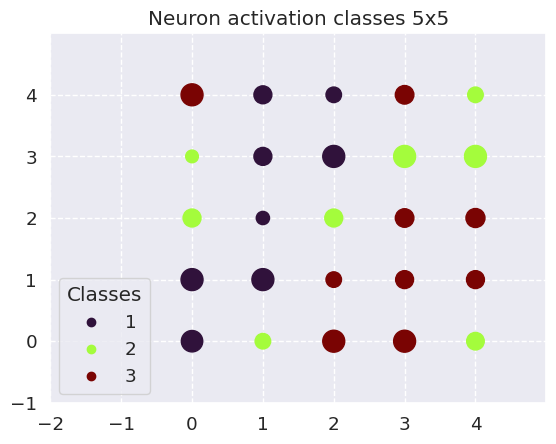

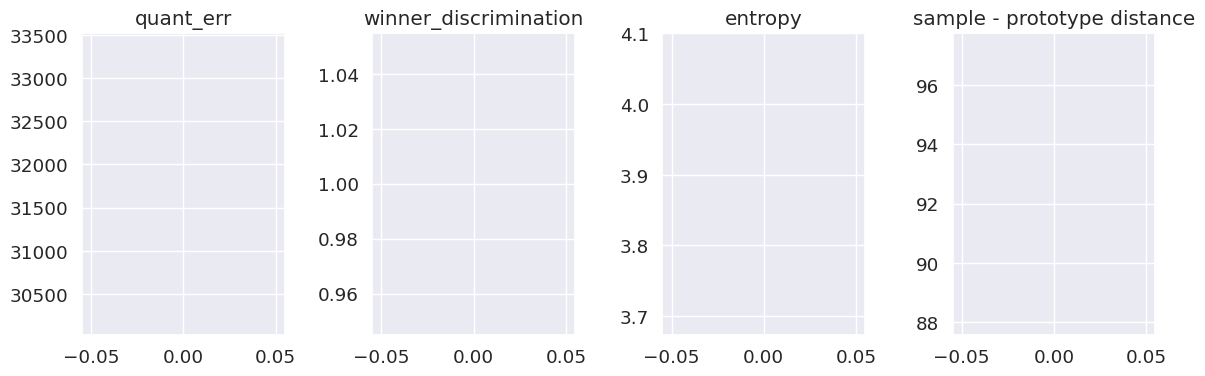

Epoch: 2 : SOM trained on new x_convs, quant_err: 12410.197265625, winner_discrimination: 0.96, entropy: 3.861621856689453, SP dist: 64.46044921875
Epoch: 3 : SOM trained on new x_convs, quant_err: 10231.6689453125, winner_discrimination: 1.0, entropy: 3.9806344509124756, SP dist: 58.17703628540039
Epoch: 4 : SOM trained on new x_convs, quant_err: 7657.23193359375, winner_discrimination: 0.92, entropy: 3.956789016723633, SP dist: 45.49006271362305
Epoch: 5 : SOM trained on new x_convs, quant_err: 7108.697265625, winner_discrimination: 0.92, entropy: 4.120846748352051, SP dist: 43.31309127807617
Epoch: 6 : SOM trained on new x_convs, quant_err: 3682.498779296875, winner_discrimination: 1.0, entropy: 4.2742486000061035, SP dist: 33.021080017089844
Epoch: 7 : SOM trained on new x_convs, quant_err: 3101.103271484375, winner_discrimination: 1.0, entropy: 4.335447311401367, SP dist: 31.046817779541016
Epoch: 8 : SOM trained on new x_convs, quant_err: 2381.181640625, winner_discrimination: 1.

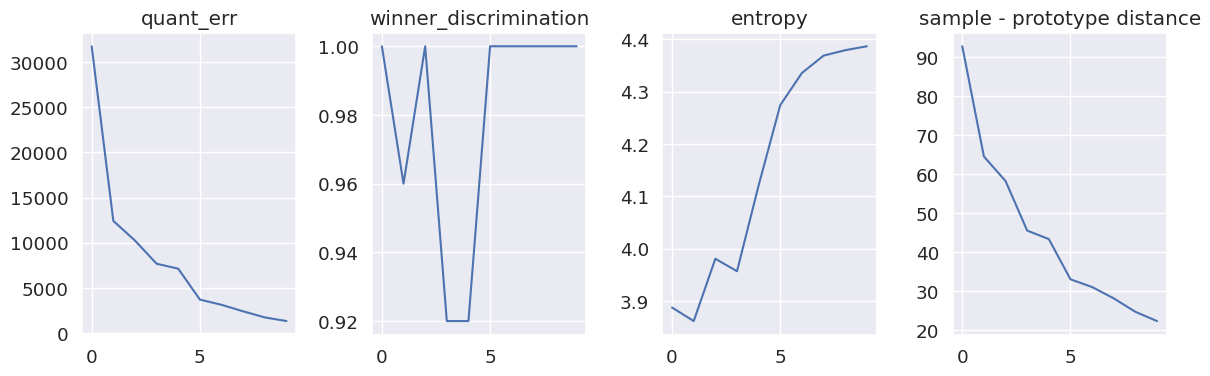

In [ ]:
EPS = 10

som = SOM(5, 5, 13, EPS, {}).to(device)
som.train()

all_quant = []
all_winner = []
all_entr = []

ds = []

for ep in range(EPS):
    som.d = {}
    print(f"Epoch: {ep+1}", end = " : ")
    with torch.no_grad():
      for batch, sample1 in enumerate(som_dataloader):
        Xs1, ys1 = sample1[:, :-1].type(torch.float32).to(device), sample1[:, -1:].type(torch.float32).to(device)

        som(Xs1, ys1, ep)

    cur_quant_err, cur_winner_discrimination, cur_entropy, dists = som.save_som_stats()


    print(f"SOM trained on new x_convs, quant_err: {cur_quant_err}, winner_discrimination: {cur_winner_discrimination}, entropy: {cur_entropy}, SP dist: {dists}", sep = "\t")

    if ep % 30 == 0:
      show_umatrix(5, 5,som.d)
      show_som_stats(som.all_quant_err, som.all_winner, som.all_entr, som.all_dists)

    ds.append(som.d)


show_som_stats(som.all_quant_err, som.all_winner, som.all_entr, som.all_dists)

In [ ]:
def train(dataloader, model, som_model, loss_fn, optimizer, kappa, ep, total_eps):
    losses = []
    sup_losses = []
    som_losses_same_cat, som_losses_dif_cat = [], []

    size = len(dataloader.dataset)
    model.train()
    for batch, paired_sample in enumerate(dataloader):
        shape1 = min(batch_size, paired_sample[:, 0:1, :].shape[0])
        sample1, sample2, sample3 = paired_sample[:, 0:1, :].reshape(shape1, 14), paired_sample[:, 1:2, :].reshape(shape1, 14), paired_sample[:, 2:3, :].reshape(shape1, 14)
        Xs1, ys1 = sample1[:, :-1].type(torch.float32).to(device), sample1[:, -1:].type(torch.float32).to(device)
        Xs2, ys2 = sample2[:, :-1].type(torch.float32).to(device), sample2[:, -1:].type(torch.float32).to(device)
        Xs3, ys3 = sample3[:, :-1].type(torch.float32).to(device), sample3[:, -1:].type(torch.float32).to(device)

        optimizer.zero_grad()

        # Compute prediction error + train som on Xs1, Xs2
        pred1 = model(Xs1)
        pred2 = model(Xs2)
        pred3 = model(Xs3)


        som_pred1 = torch.empty(shape1, 13).to(device)
        som_pred2 = torch.empty(shape1, 13).to(device)
        som_pred3 = torch.empty(shape1, 13).to(device)

        for i in range(len(Xs1)):
          som_pred1[i] = som_model.predict(Xs1[i])
          som_pred2[i] = som_model.predict(Xs2[i])
          som_pred3[i] = som_model.predict(Xs3[i])

        cur_kappa = kappa * (ep/total_eps) # linear rampup of kappa
        loss, sup_loss, som_loss_same_cat, som_loss_dif_cat = loss_fn(pred1, som_pred1, pred2, som_pred2, pred3, som_pred3, ys1, ys2, ys3, cur_kappa, True)

        # Backpropagation
        loss.backward()
        optimizer.step()


        losses.append(loss.item())
        sup_losses.append(sup_loss.item())
        som_losses_same_cat.append(som_loss_same_cat)
        som_losses_dif_cat.append(som_loss_dif_cat)


        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader):>5d}]")


    return torch.tensor(losses).mean(), torch.tensor(sup_losses).mean(), torch.tensor(som_losses_same_cat).float().mean(), torch.tensor(som_losses_dif_cat).float().mean()


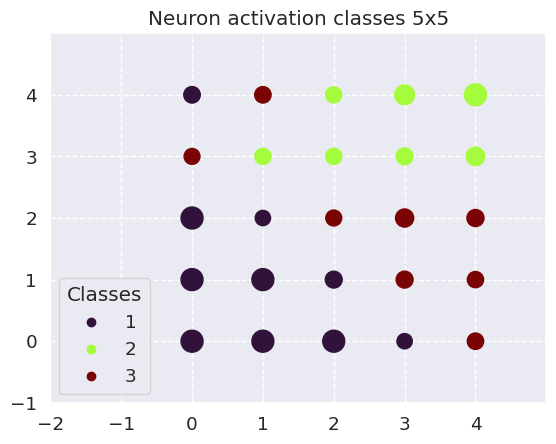

Epoch: 1
loss: 0.549897  [    0/  222]
loss: 0.501275  [  100/  222]
loss: 0.460011  [  200/  222]
Test Error: 
 Accuracy: 57.8%, Avg loss: 0.213850 



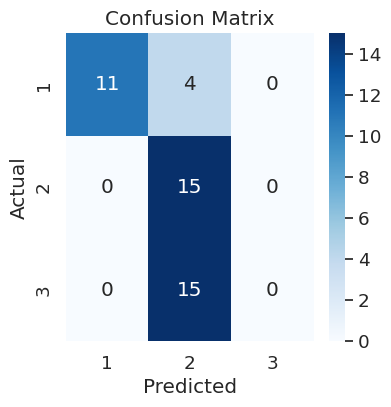

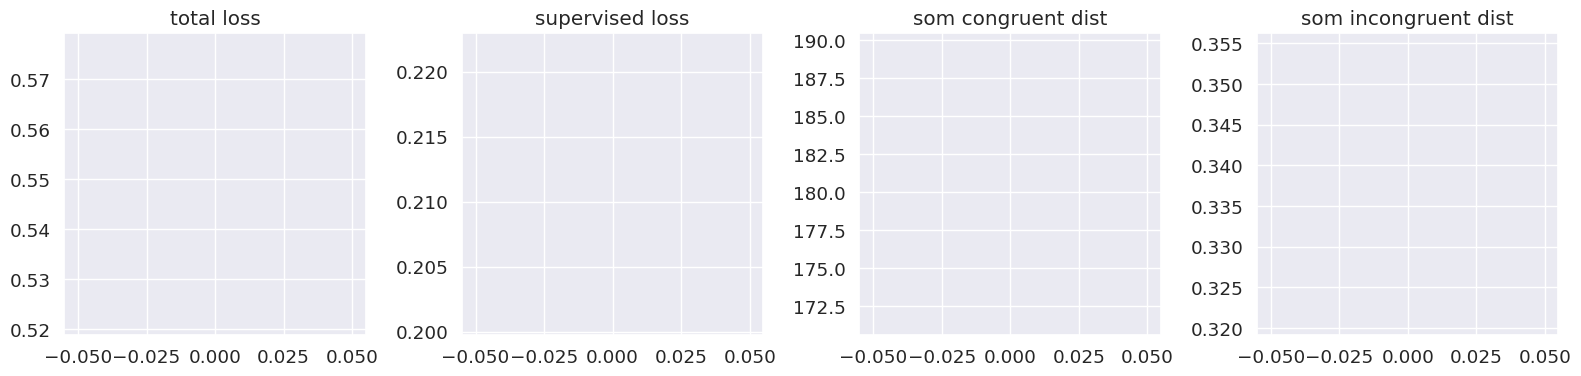

Epoch: 2
loss: 0.503097  [    0/  222]
loss: 0.417396  [  100/  222]
loss: 0.479899  [  200/  222]
Test Error: 
 Accuracy: 62.2%, Avg loss: 0.189144 



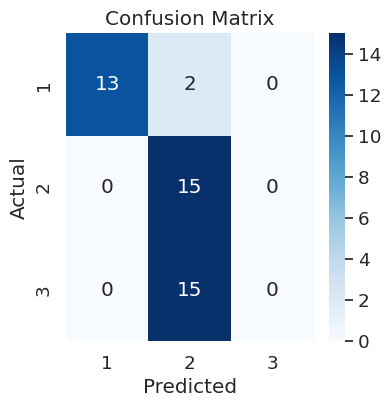

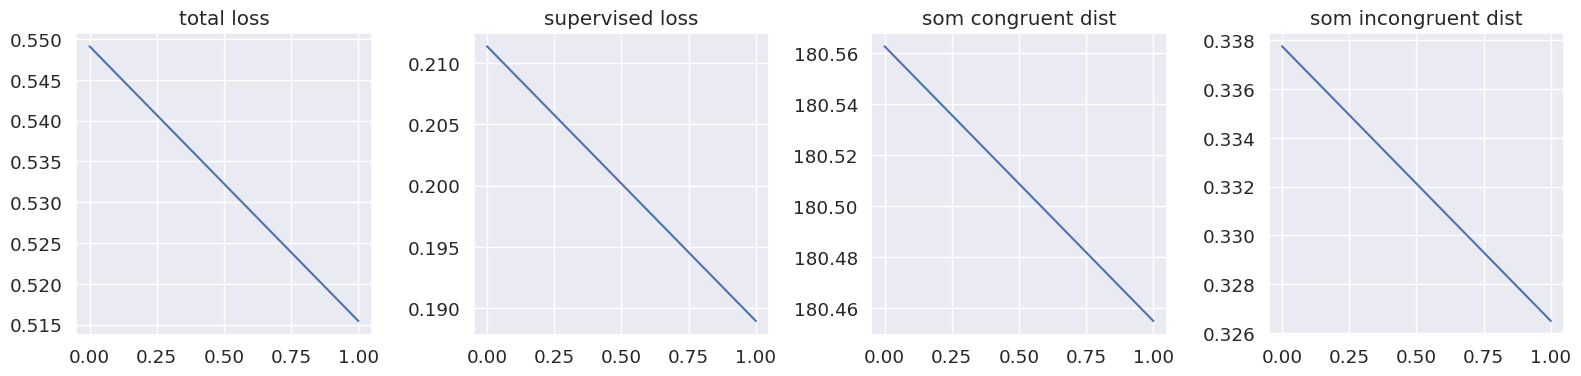

Epoch: 3
loss: 0.492463  [    0/  222]
loss: 0.385473  [  100/  222]
loss: 0.417265  [  200/  222]
Test Error: 
 Accuracy: 62.2%, Avg loss: 0.152629 



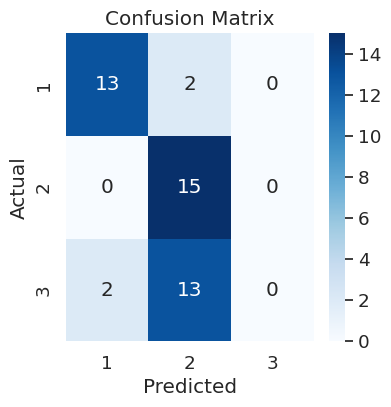

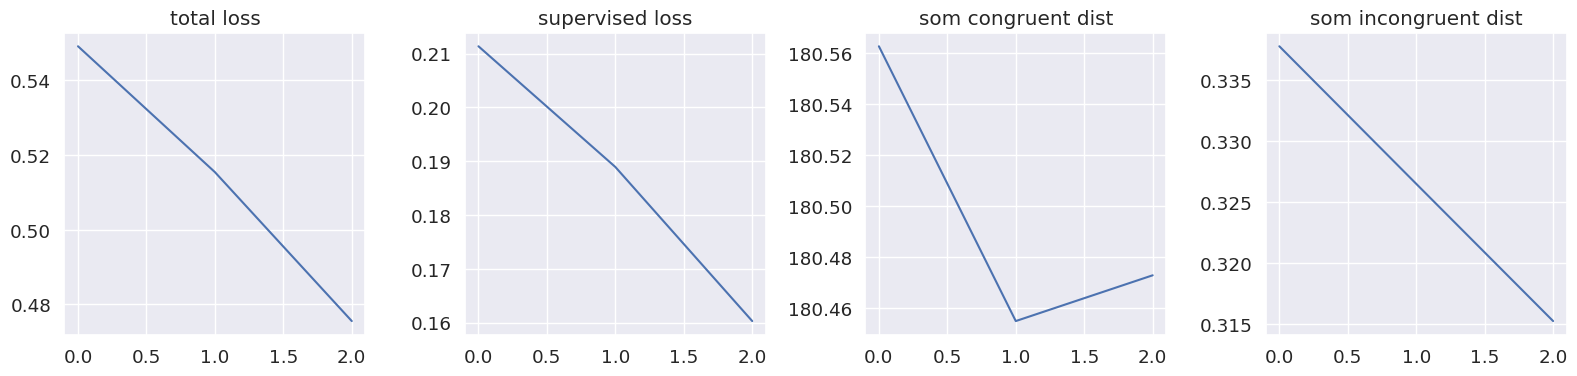

Epoch: 4
loss: 0.439039  [    0/  222]
loss: 0.394647  [  100/  222]
loss: 0.513729  [  200/  222]
Test Error: 
 Accuracy: 62.2%, Avg loss: 0.150390 



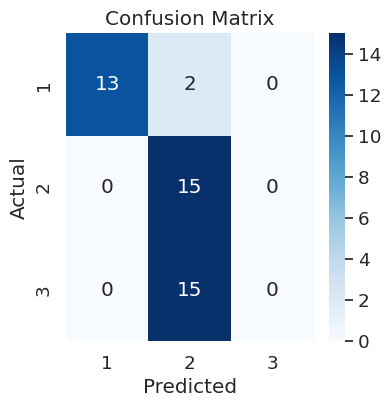

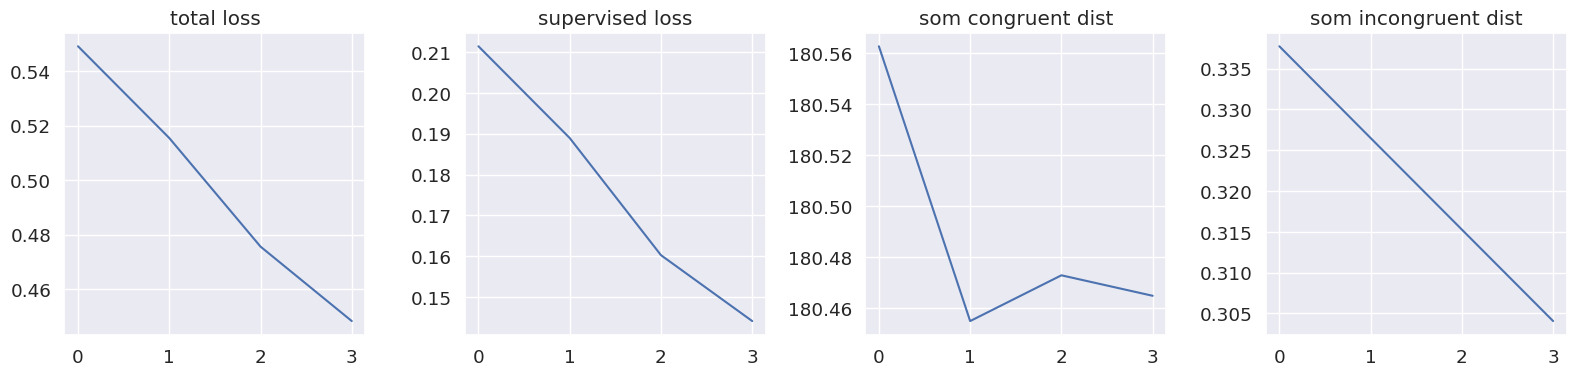

Epoch: 5
loss: 0.448994  [    0/  222]
loss: 0.431851  [  100/  222]
loss: 0.389097  [  200/  222]
Test Error: 
 Accuracy: 62.2%, Avg loss: 0.139267 



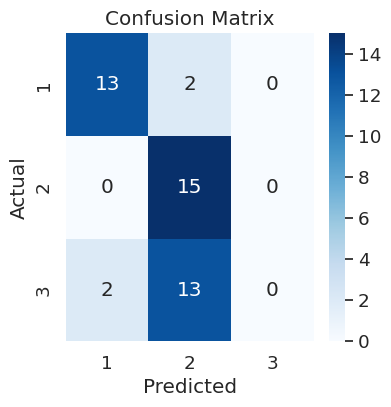

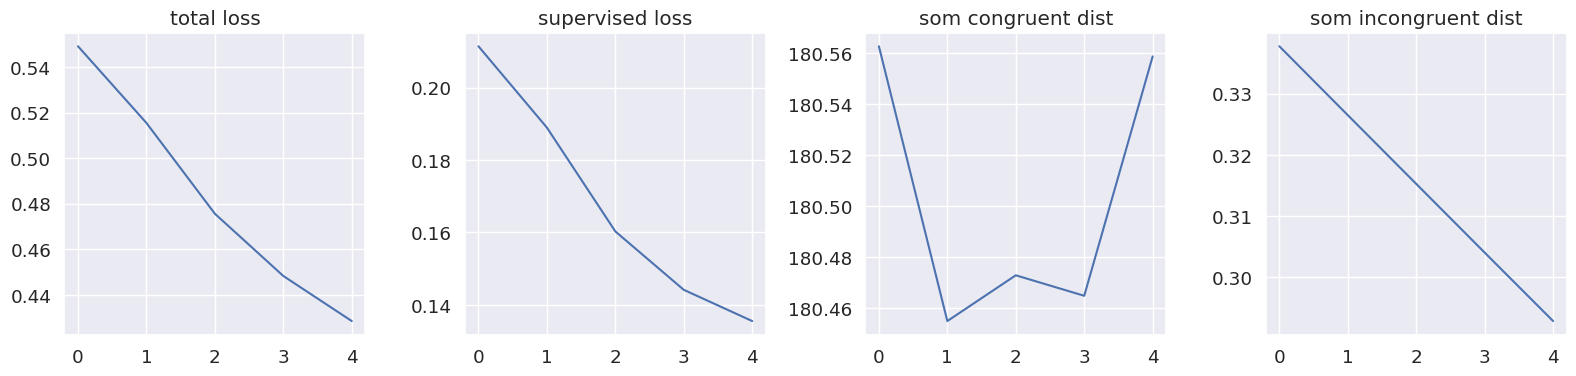

Epoch: 6
loss: 0.383262  [    0/  222]
loss: 0.407977  [  100/  222]
loss: 0.385460  [  200/  222]
Test Error: 
 Accuracy: 62.2%, Avg loss: 0.133082 



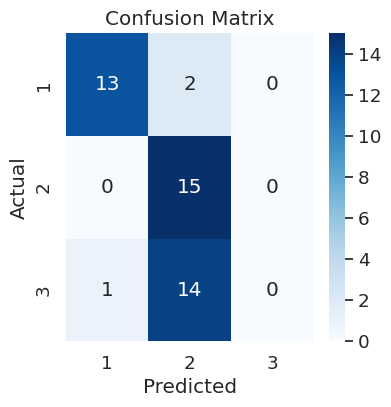

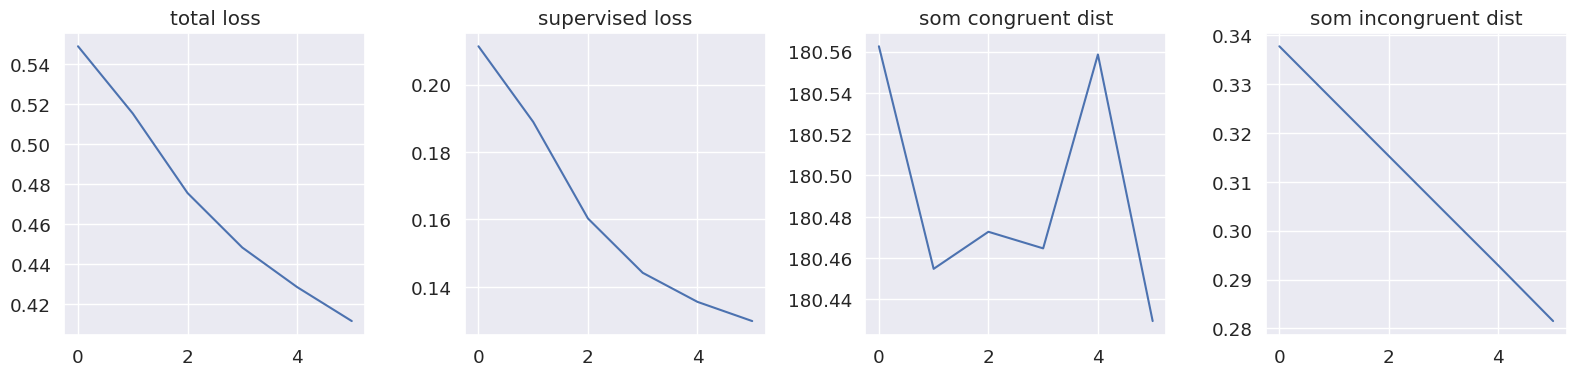

Epoch: 7
loss: 0.349526  [    0/  222]
loss: 0.406492  [  100/  222]
loss: 0.359541  [  200/  222]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.117816 



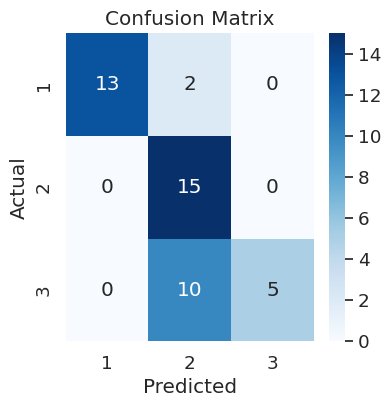

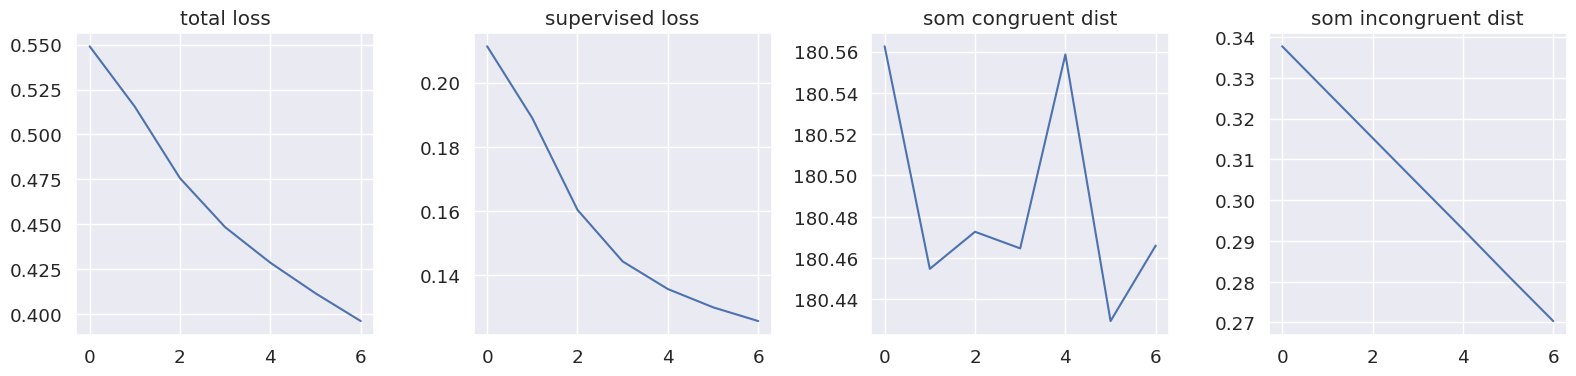

Epoch: 8
loss: 0.338553  [    0/  222]
loss: 0.353399  [  100/  222]
loss: 0.309130  [  200/  222]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.113637 



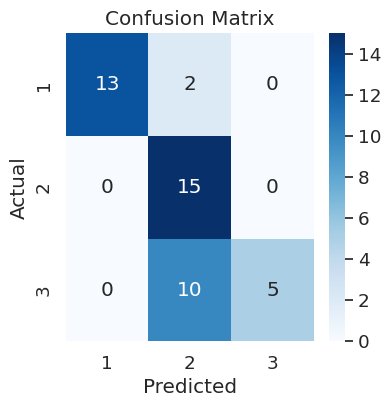

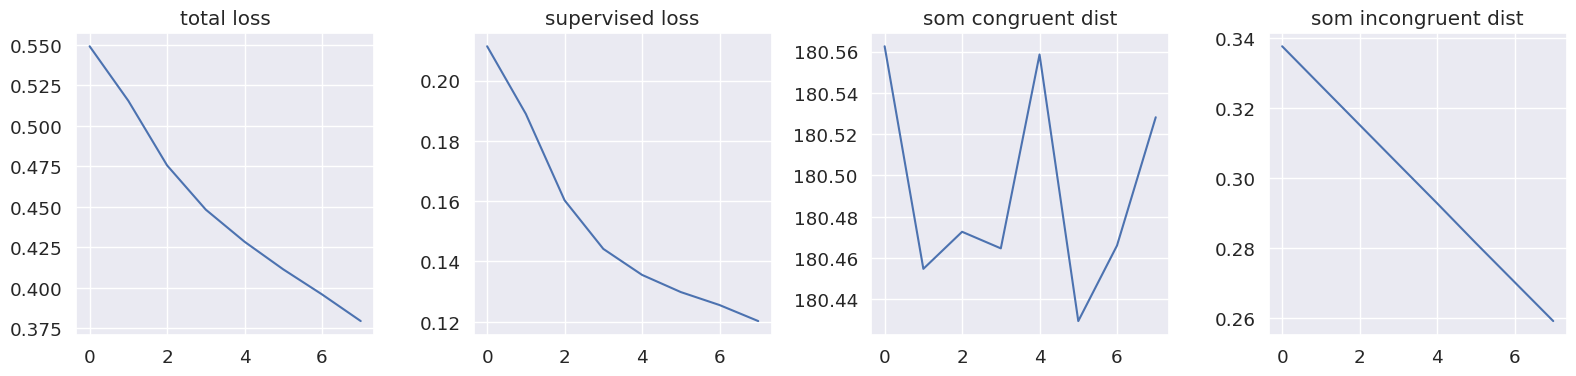

Epoch: 9
loss: 0.350995  [    0/  222]
loss: 0.386046  [  100/  222]
loss: 0.290023  [  200/  222]
Test Error: 
 Accuracy: 75.6%, Avg loss: 0.105559 



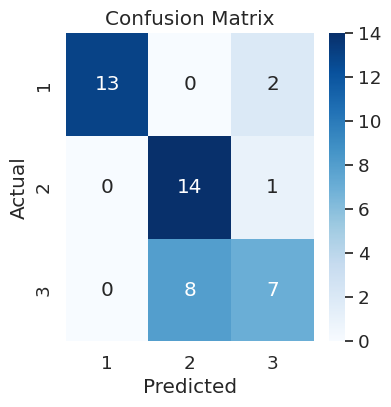

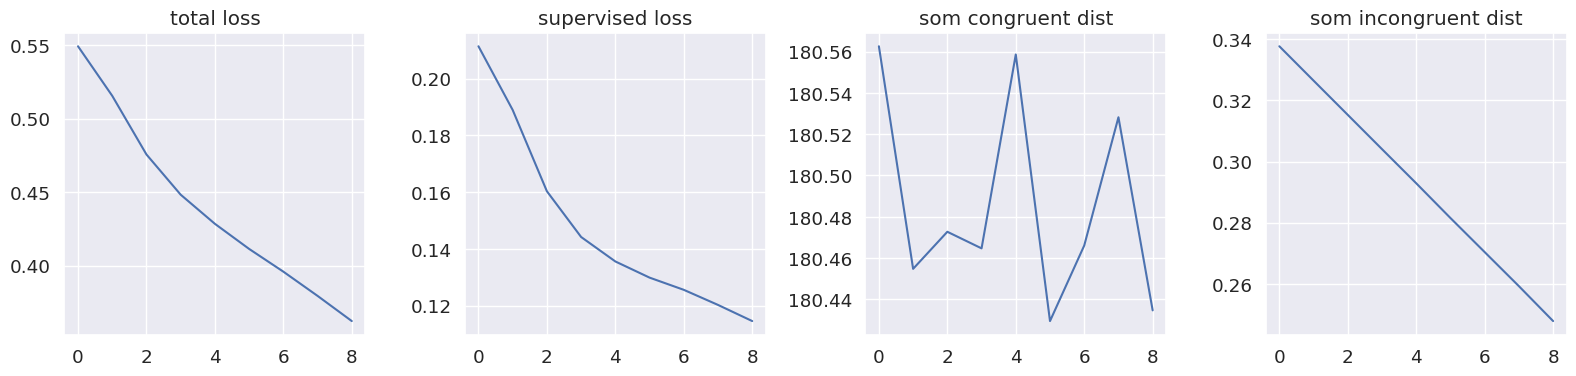

Epoch: 10
loss: 0.265076  [    0/  222]
loss: 0.245697  [  100/  222]
loss: 0.366829  [  200/  222]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.106322 



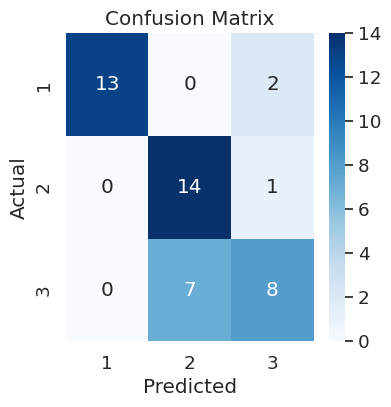

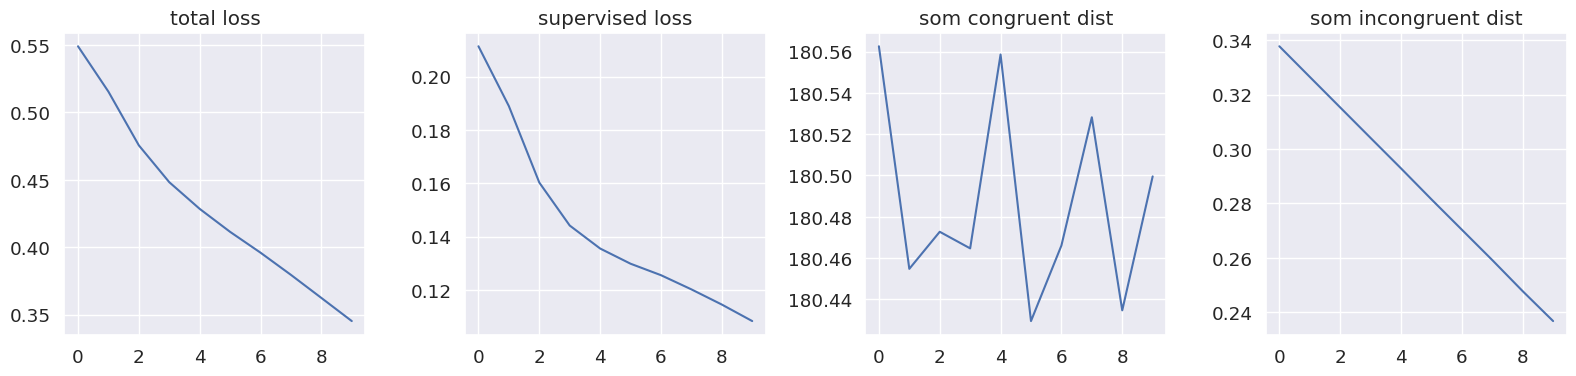

Epoch: 11
loss: 0.309284  [    0/  222]
loss: 0.267910  [  100/  222]
loss: 0.319513  [  200/  222]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.099027 



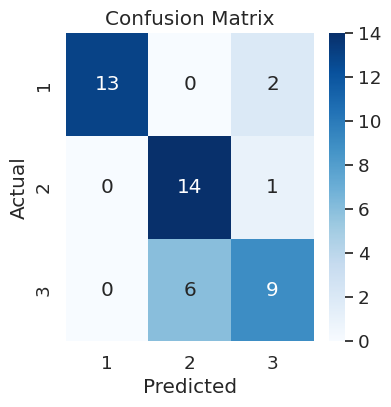

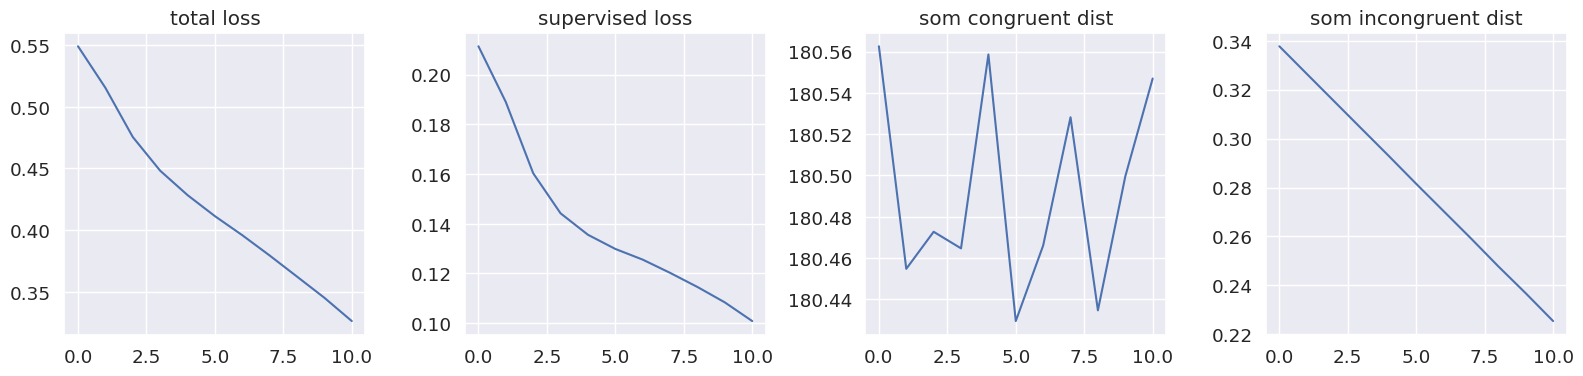

Epoch: 12
loss: 0.359860  [    0/  222]
loss: 0.289475  [  100/  222]
loss: 0.277365  [  200/  222]
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.086653 



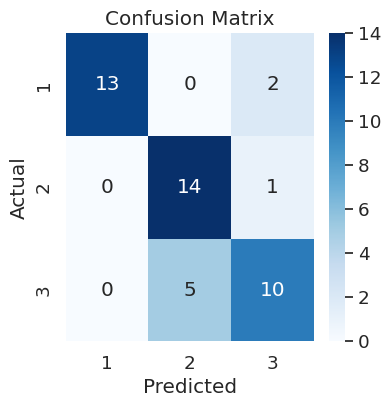

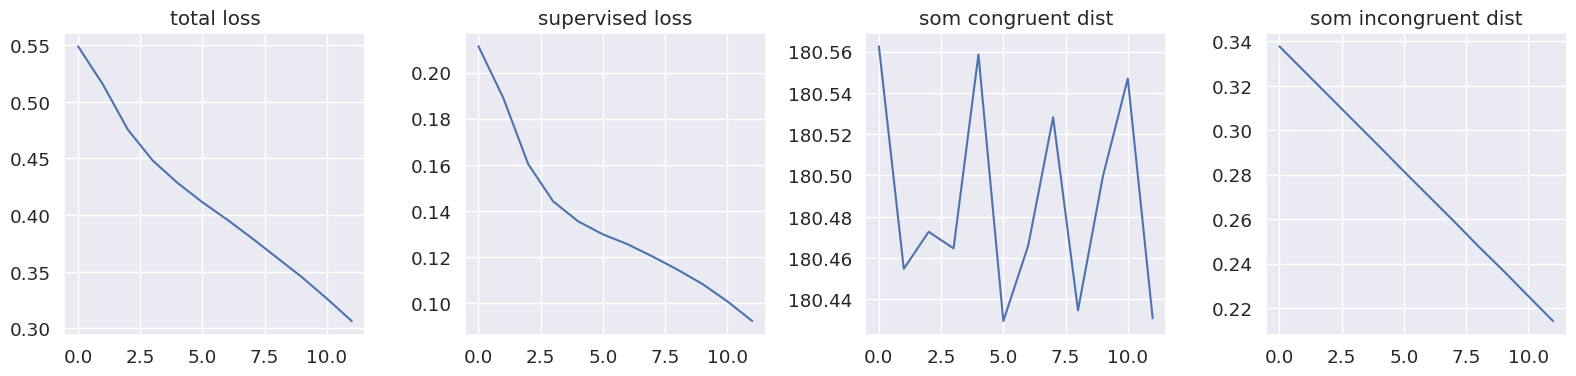

Epoch: 13
loss: 0.271474  [    0/  222]
loss: 0.335564  [  100/  222]
loss: 0.255228  [  200/  222]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.077686 



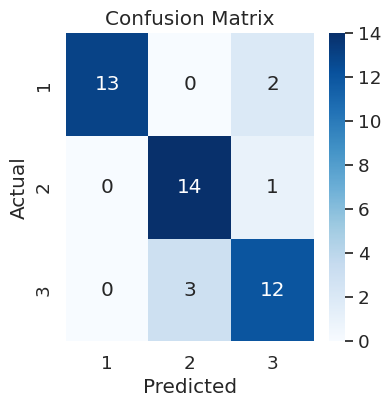

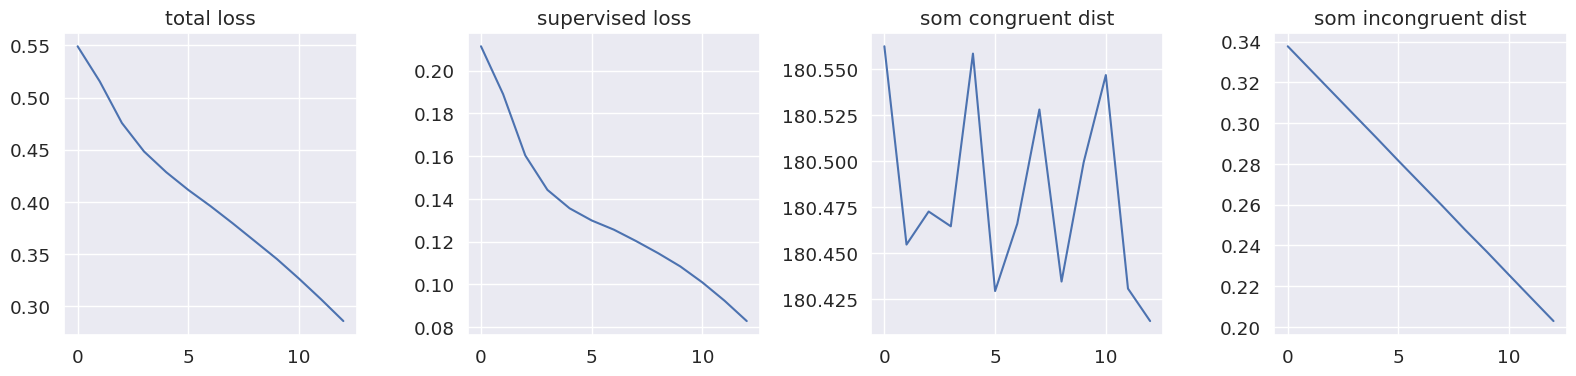

Epoch: 14
loss: 0.211344  [    0/  222]
loss: 0.263737  [  100/  222]
loss: 0.225572  [  200/  222]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.054367 



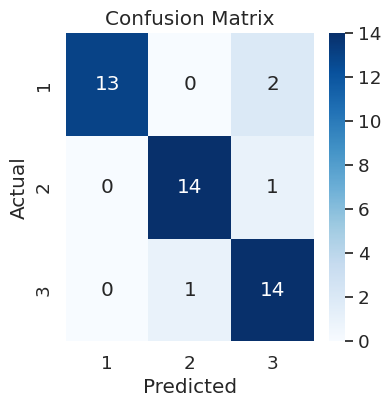

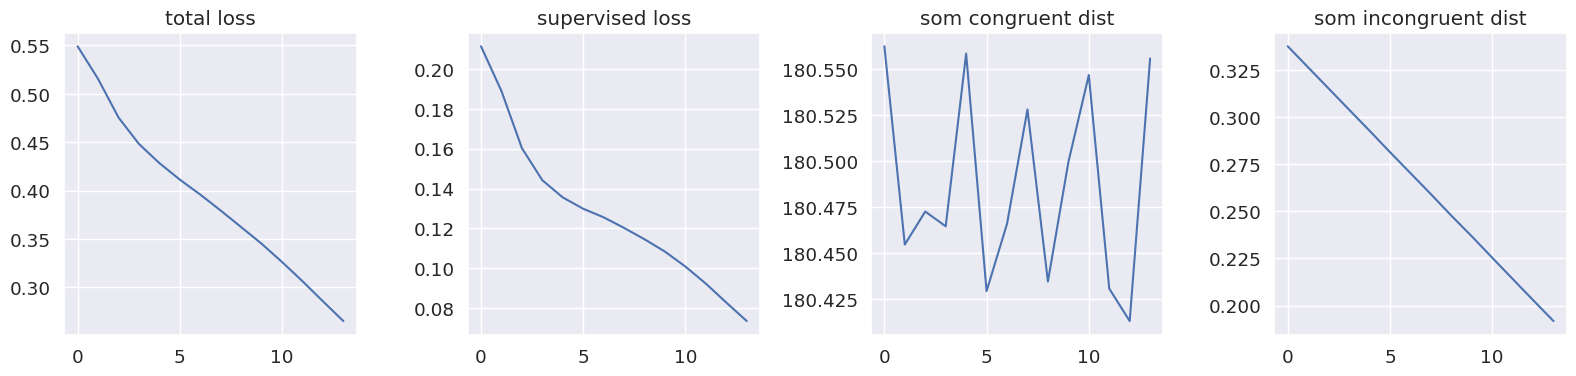

Epoch: 15
loss: 0.242736  [    0/  222]
loss: 0.247091  [  100/  222]
loss: 0.227608  [  200/  222]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.055841 



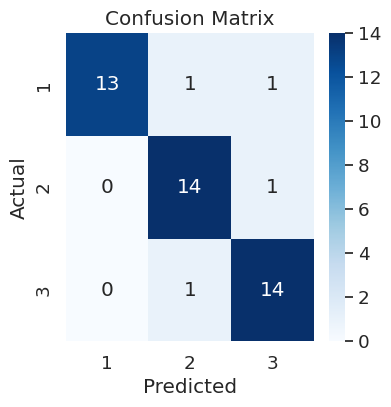

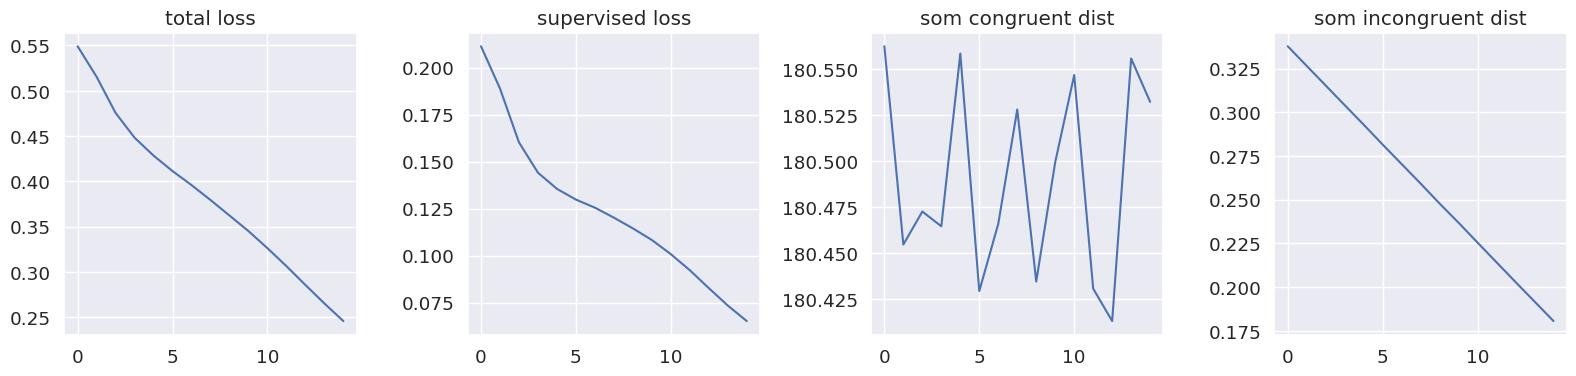

Epoch: 16
loss: 0.206478  [    0/  222]
loss: 0.145924  [  100/  222]
loss: 0.261455  [  200/  222]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.047686 



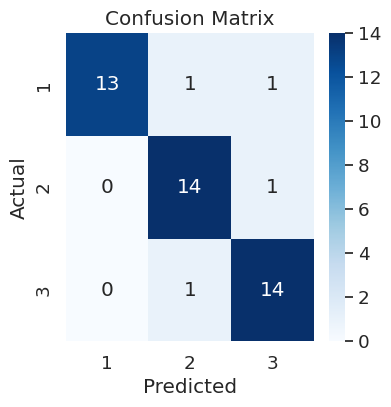

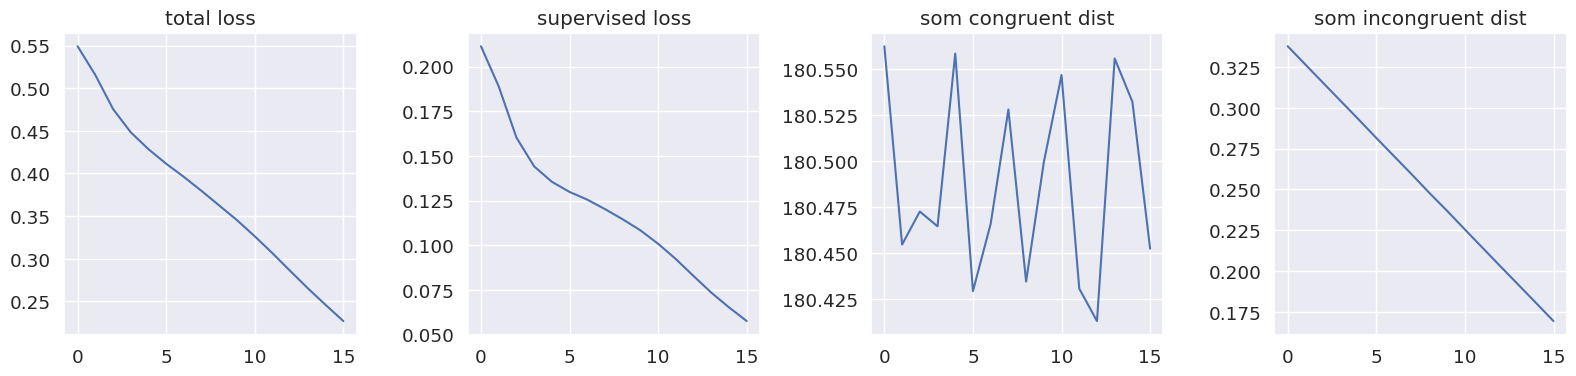

Epoch: 17
loss: 0.201643  [    0/  222]
loss: 0.222704  [  100/  222]
loss: 0.192631  [  200/  222]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.036119 



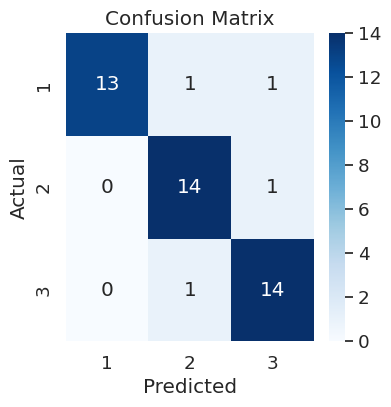

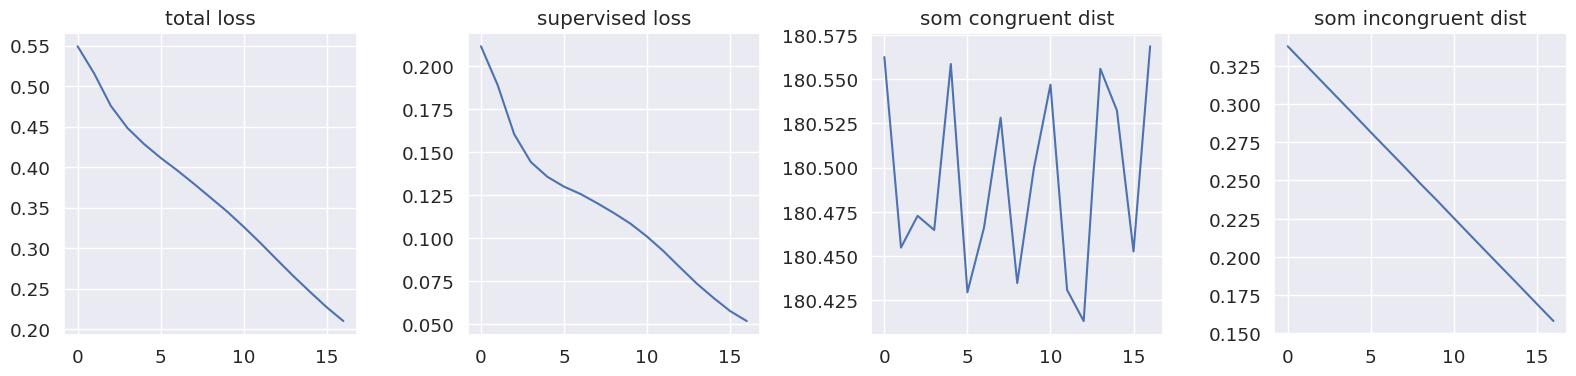

Epoch: 18
loss: 0.188903  [    0/  222]
loss: 0.155278  [  100/  222]
loss: 0.224707  [  200/  222]
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.038466 



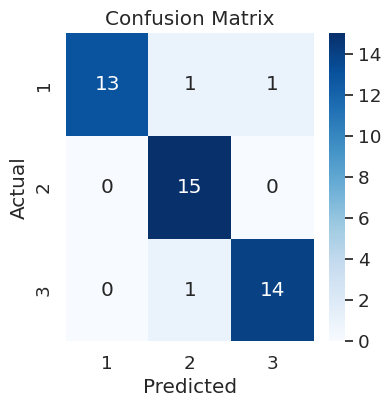

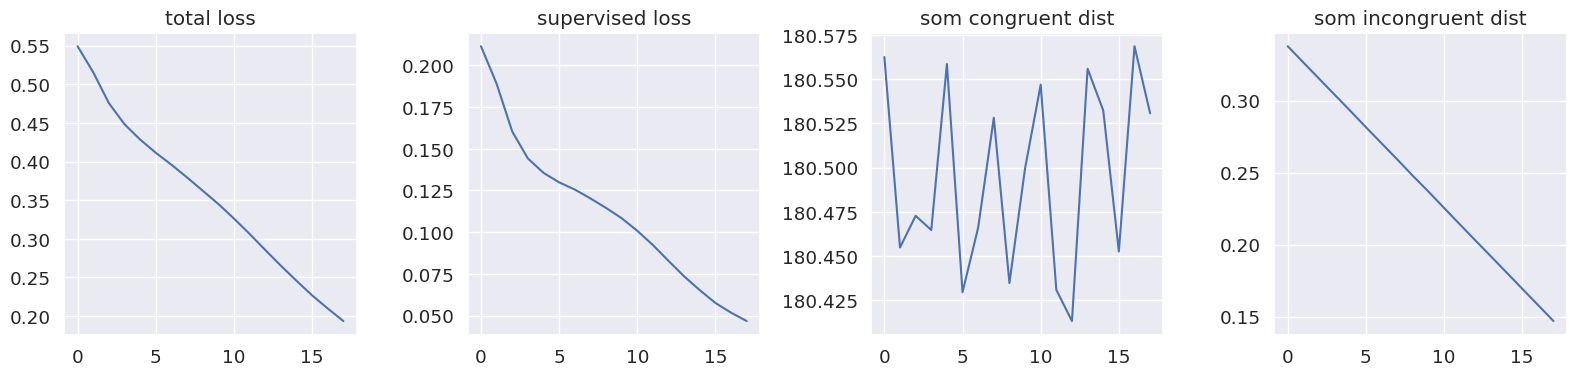

Epoch: 19
loss: 0.126929  [    0/  222]
loss: 0.162801  [  100/  222]
loss: 0.226409  [  200/  222]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.036320 



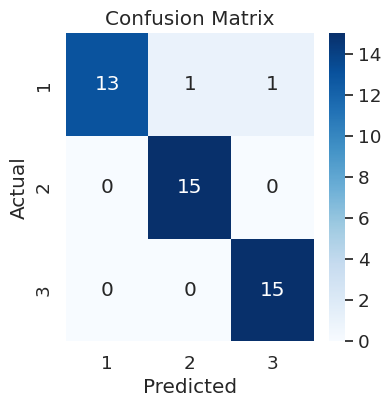

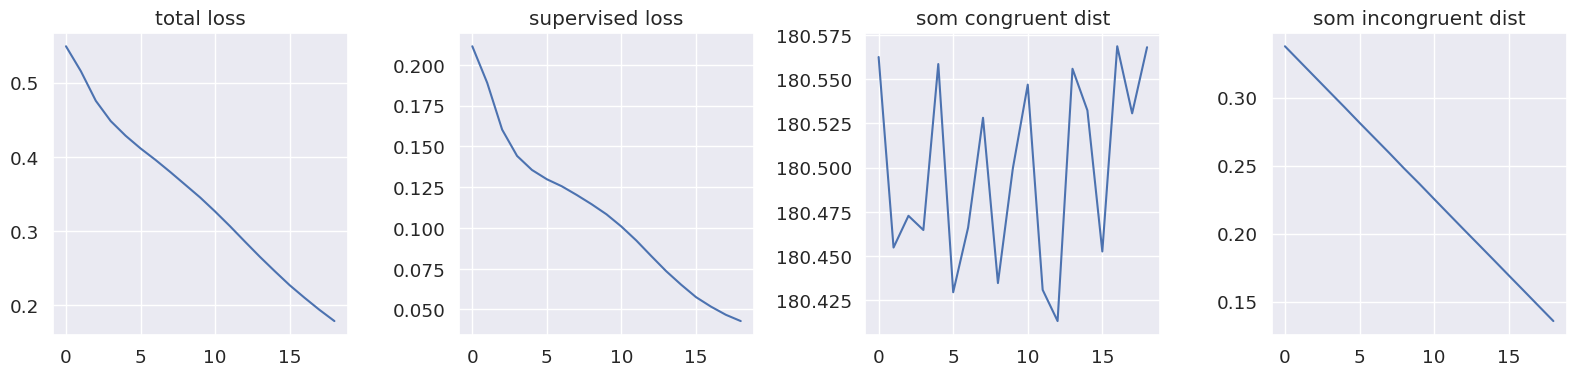

Epoch: 20
loss: 0.180239  [    0/  222]
loss: 0.213658  [  100/  222]
loss: 0.151742  [  200/  222]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.033883 



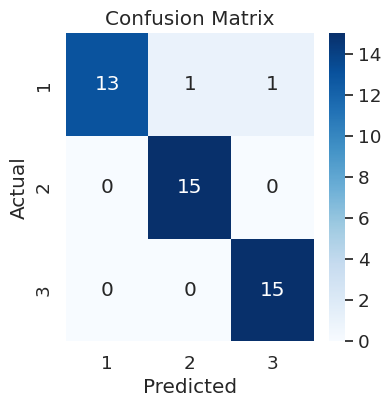

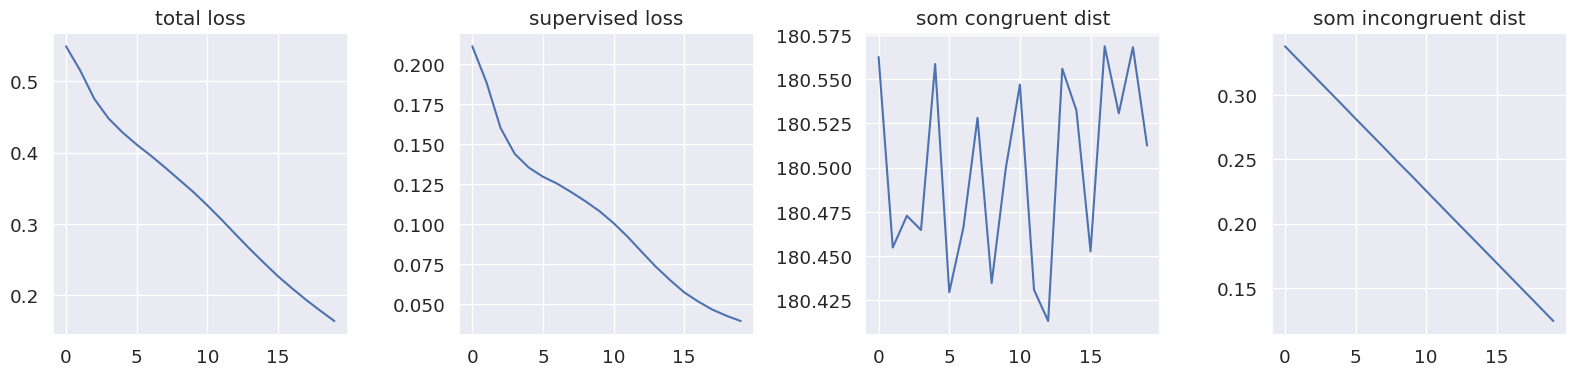

Epoch: 21
loss: 0.131888  [    0/  222]
loss: 0.155997  [  100/  222]
loss: 0.136947  [  200/  222]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.021239 



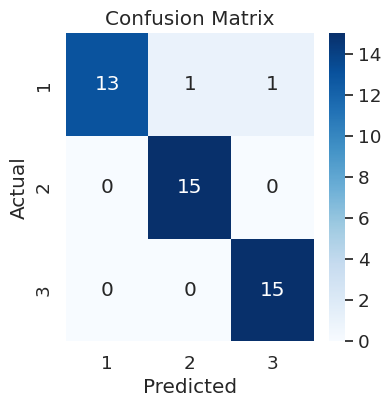

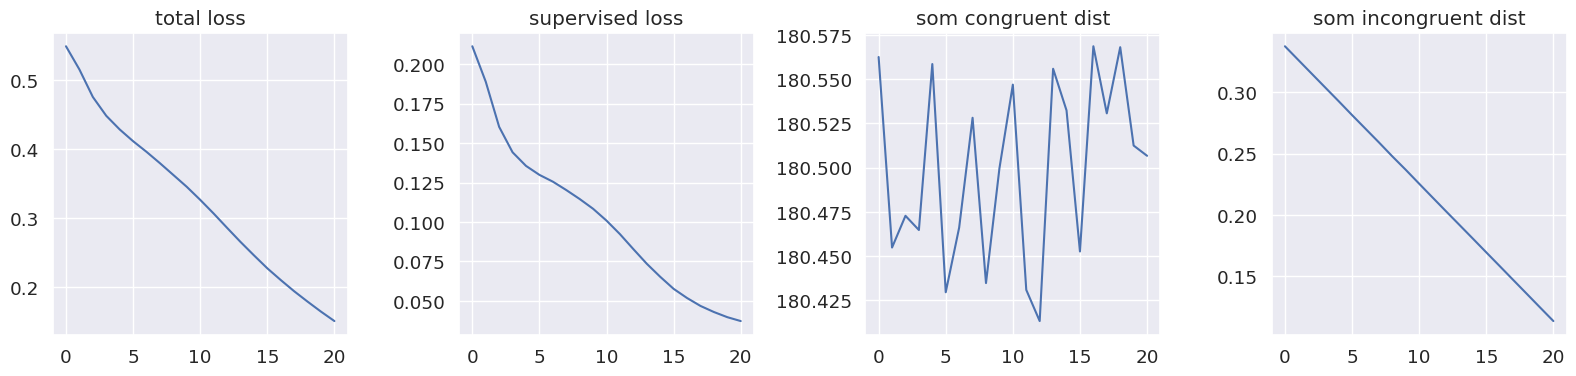

Epoch: 22
loss: 0.136291  [    0/  222]
loss: 0.151354  [  100/  222]
loss: 0.179240  [  200/  222]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.025064 



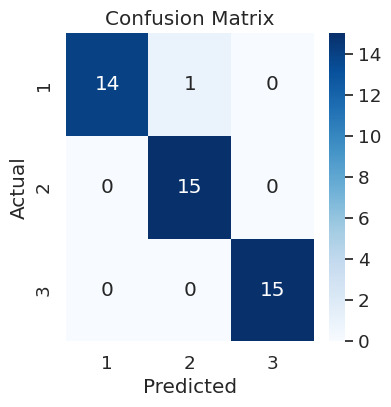

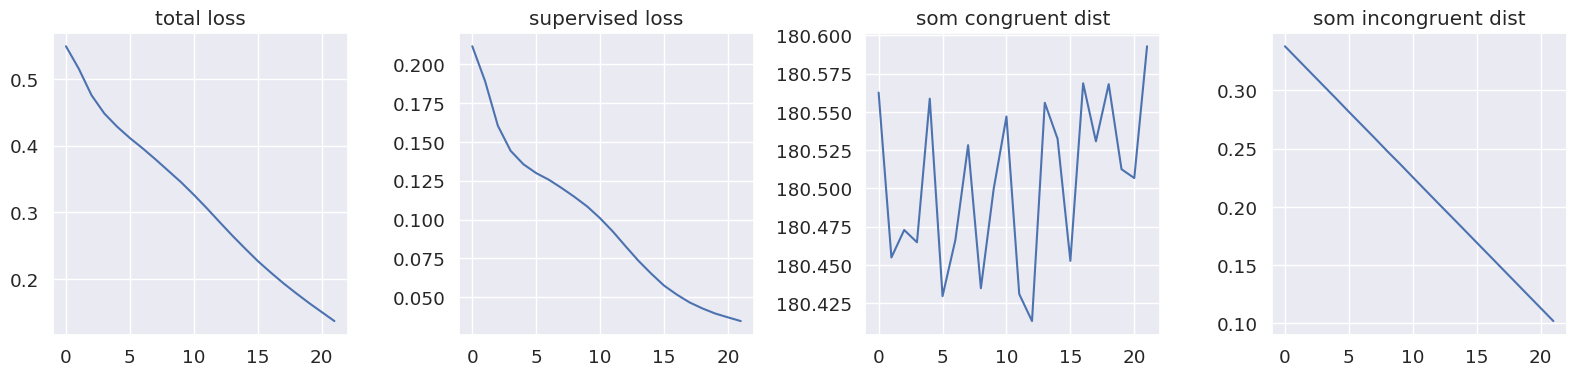

Epoch: 23
loss: 0.153336  [    0/  222]
loss: 0.112528  [  100/  222]
loss: 0.112124  [  200/  222]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.025078 



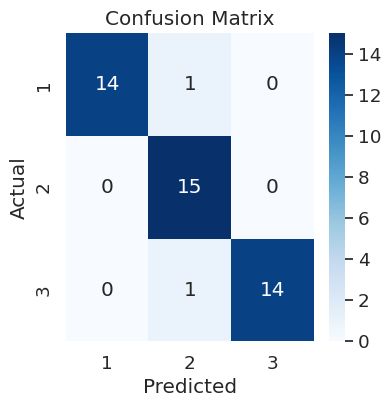

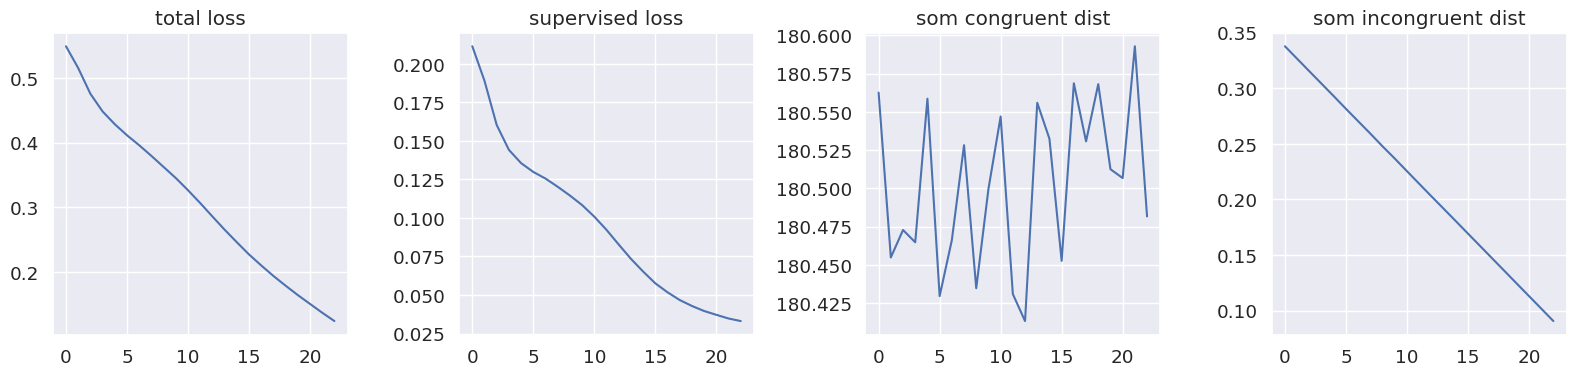

Epoch: 24
loss: 0.085718  [    0/  222]
loss: 0.098449  [  100/  222]
loss: 0.097392  [  200/  222]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.022146 



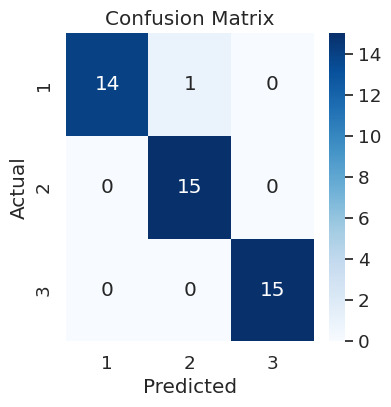

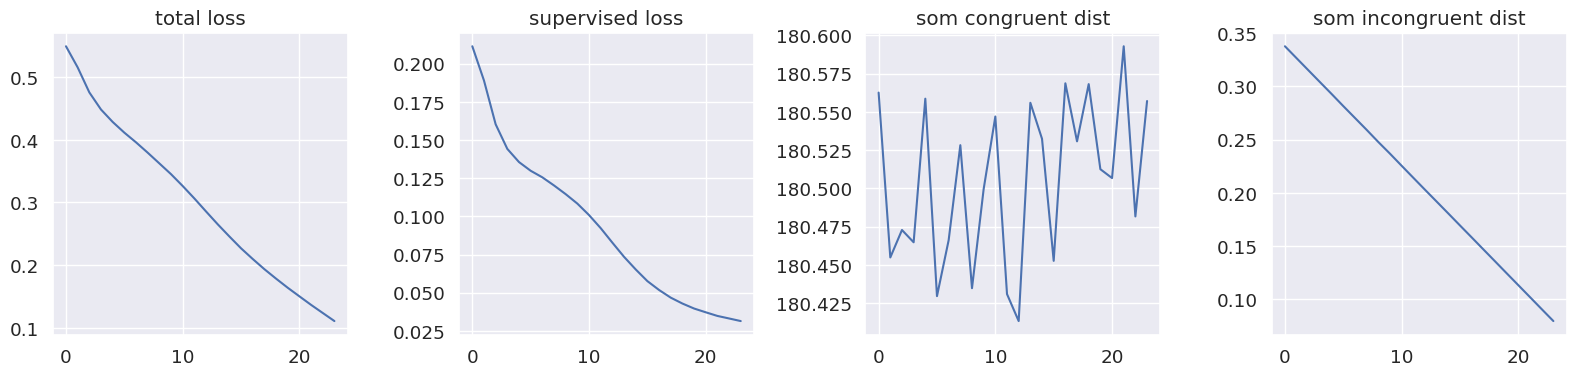

Epoch: 25
loss: 0.105675  [    0/  222]
loss: 0.101901  [  100/  222]
loss: 0.103008  [  200/  222]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018859 



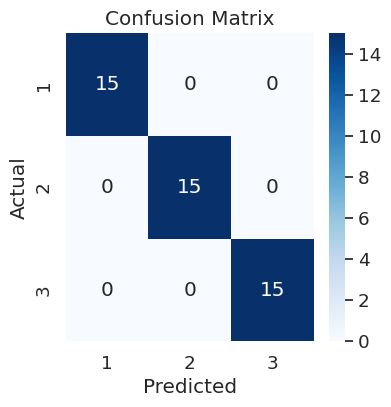

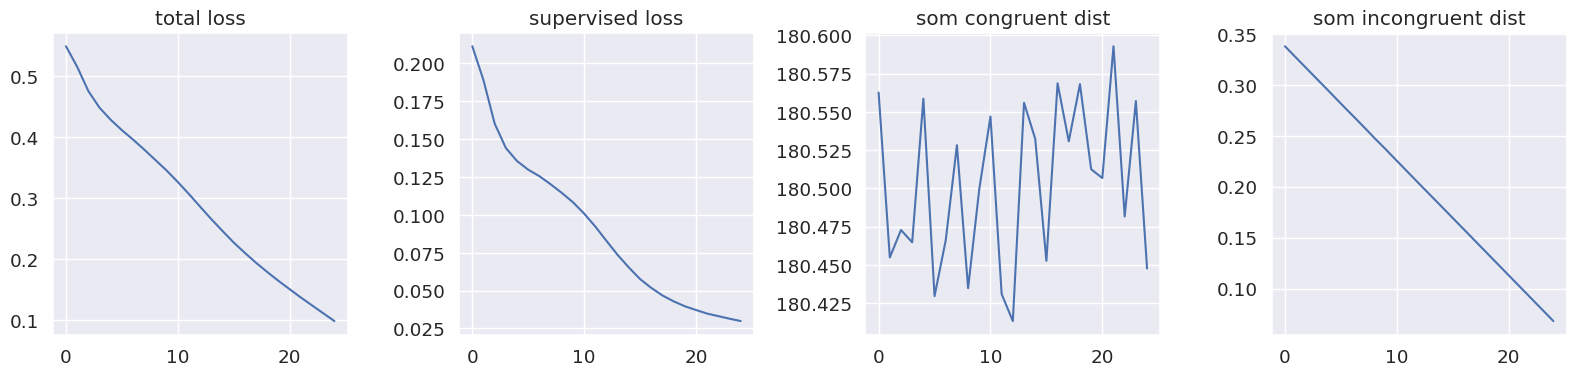

Epoch: 26
loss: 0.066932  [    0/  222]
loss: 0.095927  [  100/  222]
loss: 0.071234  [  200/  222]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.026330 



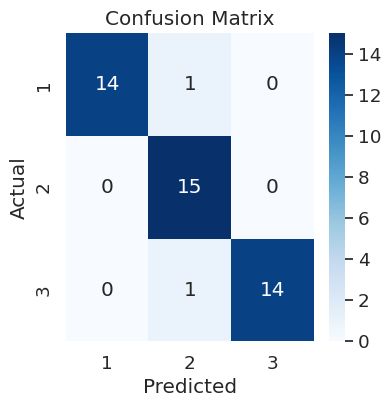

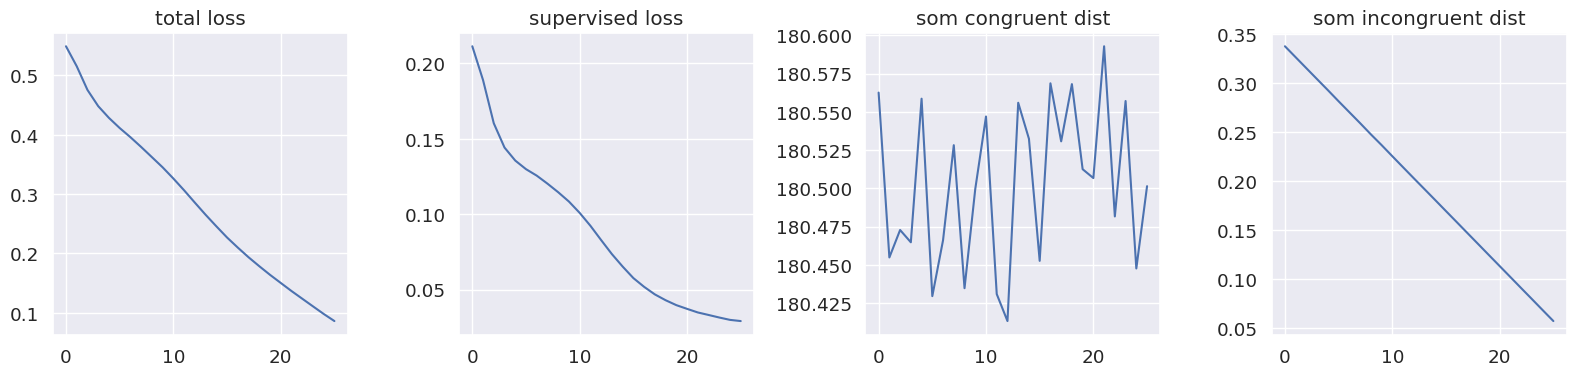

Epoch: 27
loss: 0.084220  [    0/  222]
loss: 0.072913  [  100/  222]
loss: 0.081262  [  200/  222]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.016091 



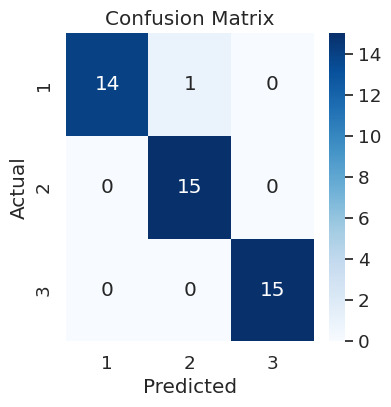

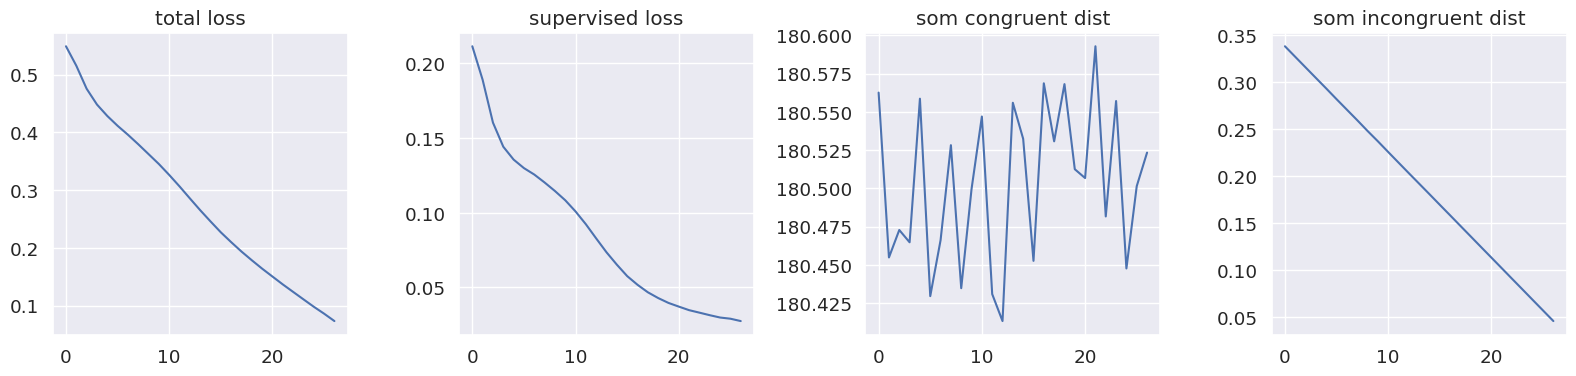

Epoch: 28
loss: 0.064226  [    0/  222]
loss: 0.049833  [  100/  222]
loss: 0.064672  [  200/  222]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015894 



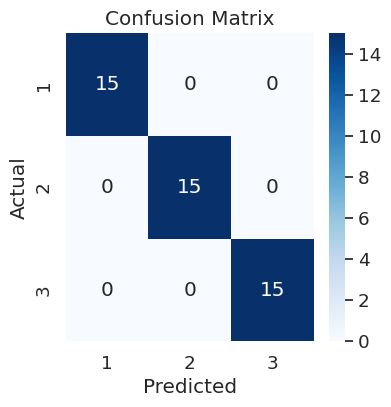

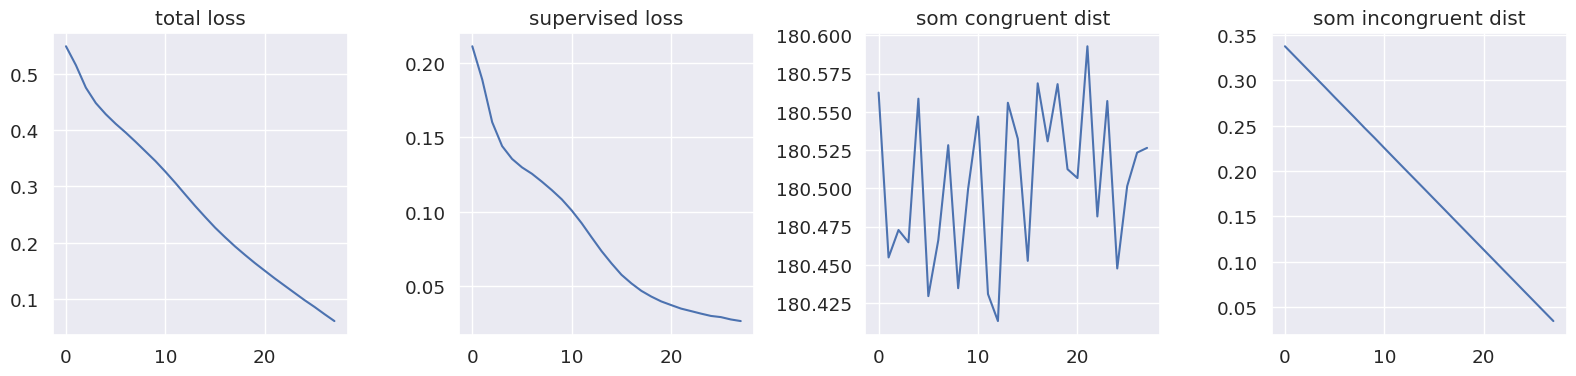

Epoch: 29
loss: 0.038000  [    0/  222]
loss: 0.027529  [  100/  222]
loss: 0.089802  [  200/  222]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.019321 



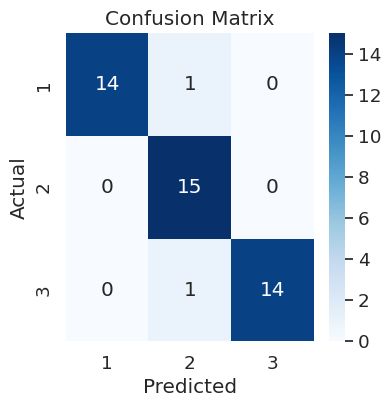

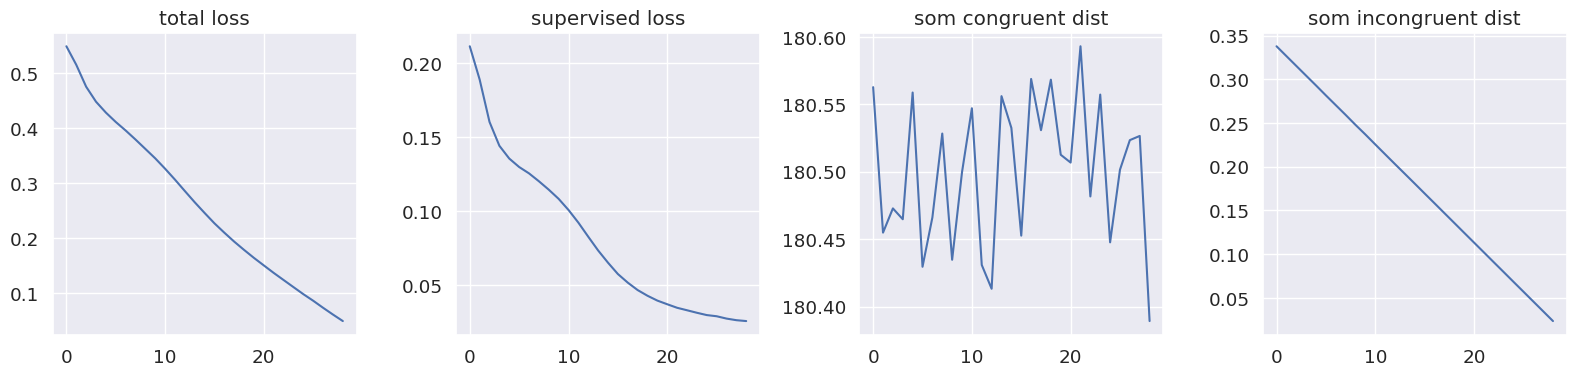

Epoch: 30
loss: 0.038119  [    0/  222]
loss: 0.050494  [  100/  222]
loss: 0.030637  [  200/  222]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.016828 



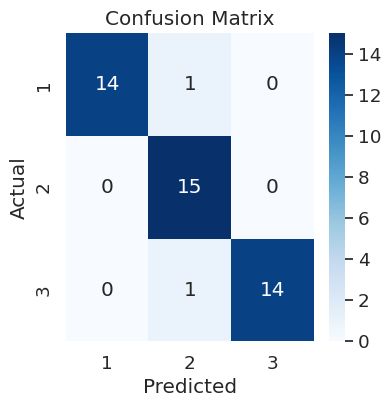

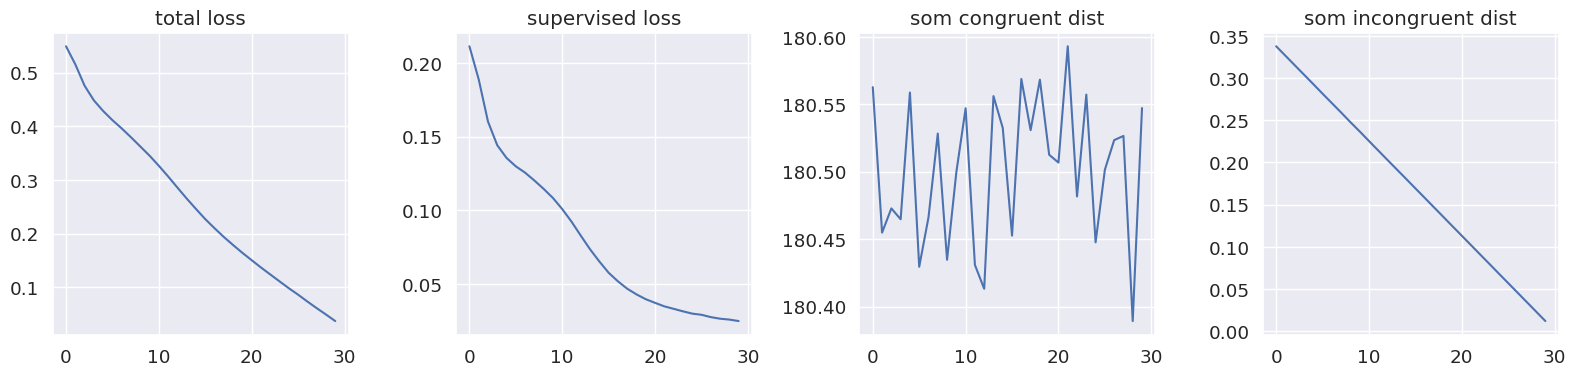

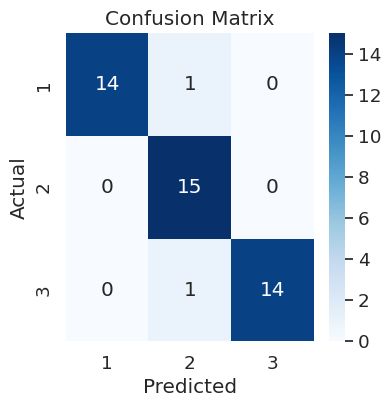

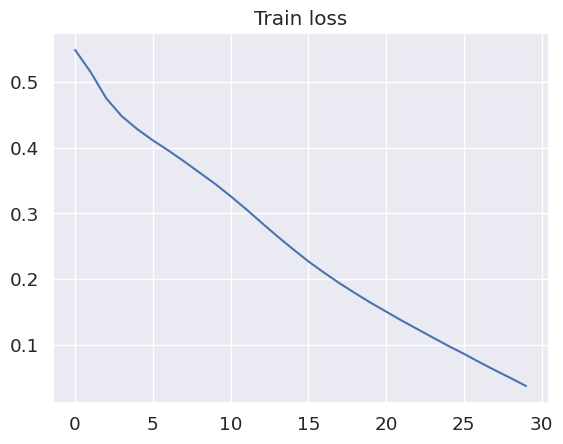

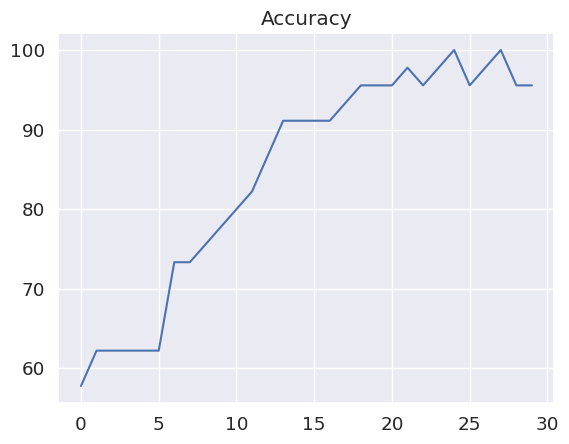

In [ ]:
mlp = NeuralNetwork().to(device)
loss_fn = SomSupLoss()
loss_fn2 = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)

kappa = 1
EPS = 50
all_losses = []
for ep in range(EPS):
    print(f"Epoch: {ep+1}")
    losses = train(train_dataloader, mlp, som, loss_fn, optimizer, kappa, ep, EPS)
    confusion, acc = test(test_dataloader, mlp, loss_fn2)



    all_losses.append(losses)
    if ep % 5 == 0:
      class_labels = ["1", "2", "3"]

      show_conf_matrix(confusion, class_labels)

class_labels = ["1", "2", "3"]
show_conf_matrix(confusion, class_labels)
plt.plot(all_losses)
print(losses)
plt.title("Train loss")
plt.show()


# MLP + SOM

In [ ]:
class NNSOM(nn.Module):
    def __init__(self, m, n, inp_dim, eps, pretr_eps, args):
        super(NNSOM, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(13, 100),
            nn.Sigmoid(),
            nn.Linear(100, 150),
            nn.Sigmoid(),
            nn.Linear(150, 3),
            nn.Softmax(dim=1)
        )
        self.m = m
        self.n = n
        self.som = SOM(m, n, inp_dim, eps, args)
        self.pretr_eps = pretr_eps

    def forward(self, x, y, ep):
        x = self.flatten(x)
        logits = self.layers(x)

        som_predictions = []
        if ep >= self.pretr_eps:
          with torch.no_grad():
            for x_som, target in zip(x, y):
              som_predictions.append(self.som(x_som, target, ep))

        return logits, som_predictions

In [ ]:
class SomSupLoss(nn.Module):
    def __init__(self):
        super(SomSupLoss, self).__init__()

    def forward(self, pred_x, som_pred_x, pred_c, som_pred_c, pred_i, som_pred_i, targets_x, targets_c, targets_i, kappa, want_som):
        loss_fn = nn.MSELoss(reduction='mean')

        sup_loss = F.mse_loss(pred_x, one_hot(targets_x, 3, 1), reduction='none').mean(dim=1)


        if want_som:
          dist_c = torch.sqrt(torch.sum(torch.pow(som_pred_x - som_pred_c, 2), dim=1))
          dist_i = torch.sqrt(torch.sum(torch.pow(som_pred_x - som_pred_i, 2), dim=1))
          som_loss = kappa * (0.5 - 0.5 * (dist_i - dist_c) / (dist_i + dist_c))
          loss = (sup_loss + som_loss).mean()
        else:
          loss = sup_loss.mean()

        # print("computed loss: ", loss)
        return loss, sup_loss.mean(), dist_c.mean() if want_som else 0, dist_i.mean() if want_som else 0

In [ ]:
def train(dataloader, model, loss_fn, optimizer, kappa, ep, total_eps):
    losses = []
    sup_losses = []
    som_losses_same_cat, som_losses_dif_cat = [], []

    size = len(dataloader.dataset)
    model.train()
    for batch, paired_sample in enumerate(dataloader):
        shape1 = min(batch_size, paired_sample[:, 0:1, :].shape[0])
        sample1, sample2, sample3 = paired_sample[:, 0:1, :].reshape(shape1, 14), paired_sample[:, 1:2, :].reshape(shape1, 14), paired_sample[:, 2:3, :].reshape(shape1, 14)
        Xs1, ys1 = sample1[:, :-1].type(torch.float32).to(device), sample1[:, -1:].type(torch.float32).to(device)
        Xs2, ys2 = sample2[:, :-1].type(torch.float32).to(device), sample2[:, -1:].type(torch.float32).to(device)
        Xs3, ys3 = sample3[:, :-1].type(torch.float32).to(device), sample3[:, -1:].type(torch.float32).to(device)

        optimizer.zero_grad()

        # Compute prediction error + train som on Xs1, Xs2
        pred1, som_pred1 = model(Xs1, ys1, ep)
        pred2, som_pred2 = model(Xs2, ys2, ep)
        pred3, som_pred3 = model(Xs3, ys3, ep)


        if som_pred1 != []:
            som_pred1 = torch.stack(som_pred1)
            som_pred2 = torch.stack(som_pred2)
            som_pred3 = torch.stack(som_pred3)

        cur_kappa = kappa * (ep/total_eps) # linear rampup of kappa
        loss, sup_loss, som_loss_same_cat, som_loss_dif_cat = loss_fn(pred1, som_pred1, pred2, som_pred2, pred3, som_pred3, ys1, ys2, ys3, cur_kappa, ep >= model.pretr_eps)

        # Backpropagation
        loss.backward()
        optimizer.step()


        losses.append(loss.item())
        sup_losses.append(sup_loss.item())
        som_losses_same_cat.append(som_loss_same_cat)
        som_losses_dif_cat.append(som_loss_dif_cat)


        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader):>5d}]")


    return torch.tensor(losses).mean(), torch.tensor(sup_losses).mean(), torch.tensor(som_losses_same_cat).float().mean(), torch.tensor(som_losses_dif_cat).float().mean()


def test(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predicted_values, real_values = [], []

    with torch.no_grad():
        for sample in dataloader:

            Xs1, ys1 = sample[:, :-1].type(torch.float32).to(device), sample[:, -1:].type(torch.float32).to(device)
            pred1 = model(Xs1, ys1, -1)[0].to(device)

            predicted_values += list(pred1.argmax(1))
            real_values += list((ys1-1).squeeze())

            test_loss += loss_fn(pred1, one_hot(ys1, 3, 1)).item()
            correct += (pred1.argmax(1) == (ys1-1).squeeze()).type(torch.float).sum().item()

    predicted_values = torch.tensor(predicted_values)
    real_values = torch.tensor(real_values)
    confusion = confusion_matrix(real_values, predicted_values)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return confusion, 100*correct


In [ ]:
EPS = 50
PRETR_EPS = 1
nnsom = NNSOM(5, 5, 13, EPS,PRETR_EPS, {}).to(device)
optimizer = torch.optim.Adam(nnsom.parameters(), lr=0.0001)
kappa = 10
loss_fn = SomSupLoss()

# make_dot(nnsom, params=dict(nnsom.named_parameters())).render("attached", format="png")

t = time.time()
all_losses = []
all_sup_losses = []
all_som_same_losses, all_som_dif_losses = [], []
accs = []

for ep in range(EPS):
    print(f"Epoch: {ep+1} \t el.time: {time.time()-t}")

    """for name, param in nnsom.named_parameters():
      if param.requires_grad:
          print(f"Parameter name: {name}")
          print(f"Parameter shape: {param.shape}")
          print(f"Parameter values: {param.data}")
          break"""

    losses, sup_losses, som_losses_same_cat, som_losses_dif_cat = train(train_dataloader, nnsom, loss_fn, optimizer, kappa, ep, EPS)
    all_losses.append(losses)
    all_sup_losses.append(sup_losses)
    all_som_same_losses.append(som_losses_same_cat)
    all_som_dif_losses.append(som_losses_dif_cat)

    loss_fn2 = MSELoss()
    confusion, acc = test(test_dataloader, nnsom, loss_fn2)
    accs.append(acc)
    if ep % 1 == 0:
      # umatrix(nnsom.m, nnsom.n, nnsom.som.d)

      class_labels = ["1", "2", "3"]

      show_conf_matrix(confusion, class_labels)

    show_3losses(Losses4(all_losses, all_sup_losses, all_som_same_losses, all_som_dif_losses))
    # print(nnsom.m, nnsom.n, nnsom.som.d)

    if ep >= PRETR_EPS:
      nnsom.som.save_som_stats()
      # show_som_stats(som.all_quant_err, som.all_winner, som.all_entr, som.all_dists)
      show_umatrix(nnsom.m, nnsom.n, nnsom.som.d)

plt.plot(accs)
plt.title("Accuracy")
plt.show()